# Reddit Knows You - Predict Reddit user personalities based on comments 

### Contents
1. Introduction 
2. Import Packages and Data 
3. Data Cleaning & Initial EDA
4. Text Processing 
5. Simple Models
6. SpaCy Text Processing
7. Models & Grid Search
8. Dealing with Imbalanced Data 
9. Models
10. LDA Topic Modelling
11. Limitations
12. Future Improvements
13. Conclusion


## Introduction

Nicknamed “Front Page of the Internet”, Reddit has always been a conglomerate of information since its inception in 2005. In 2018 alone, there are 153 million posts and 1.2 billion comments added to this popular online forum (Reddit, 2018). As one of the most popular websites on the internet, the high volume of daily activity is valued by advertisers, but Reddit seems like a hard place to crack.

Unlike other social networks such as Facebook and Instagram, users can post anonymously , thus granted more freedom. But do the posts still somehow reveal who we are deep down? This project aims to  predict what type of personality (MBTI) the user is based on their posts. 

## Import Packages and Data


In [2]:
# regular packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import os
import string


# nltk 
import nltk 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Doylism/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# import data 
df = pd.read_csv('../../../original_data/mbti_reddit_1.csv', index_col=0)

In [5]:
df.head(10)

,body,subreddit,author
flair_text,,,
INFP: The Dreamer Senpai,Lol that's why I left.,entp,LadyBanterbury
INTP: The Theorist,"I was just about to post ""I try telling people...",INTP,Finarin
INFP: The Dreamer,My first thought was Pepsi or something. Proba...,WTF,xanplease
"ENTP: Antisocial Extrovert, Rational Eccentric","Not if the formula is something like ""every ti...",youtubehaiku,HeirToGallifrey
INTP/18/m/blankly staring at you,Does this imply I'm a five now?,entp,lightfive
INTP: The Theorist,"Well, I wouldn't know but I think there's a lo...",InternetIsBeautiful,ElementalVoltage
The INFJ Dude,"sine na, support the directors, actors and oth...",Philippines,BabyFlo70
Honorary INFP; INTP/21/F,I use just enough vacation days so that I don'...,tumblr,RockinSocksReborn
intp or something of the sort,Can be ur angle... or you're devil ;),woof_irl,crowbird_


## Data Cleaning & Initial EDA

The original dataset was separated into 17 csv files, each containing around 1.5 million user comments from Reddit. I decided to use only a portion of the data due to computation and time restrain. First I loaded in one file and examine the data.

We can see that the personality type is contained in the users' flair_text, aka their signatures. Therefore, the first step is to do some feature engineering to extract the personality types from their flair text.

### Feature Engineering

In [141]:
# extract MBTI from flair text 

mbti = ['INFP','INFJ','INTP','INTJ','ENTP','ENFP','ISTP','ISFP','ENTJ','ISTJ','ENFJ','ISFJ','ESTP','ESFP','ESFJ','ESTJ']
pat = '|'.join(r"\b{}\b".format(x) for x in mbti)

df['personality'] = df['flair_text'].str.findall(pat, flags=re.I).str.join(' ')

In [142]:
# transform text in personality column to all upper case 
df['personality'] = df['personality'].str.upper()

Some users have multiple MBTI personalities in their flair texts, after examing the flairs, I decide to only keep the first one. 

In [144]:
# split the first MBTI indicator from the rest 
new = df['personality'].str.split(' ', n=1, expand=True)

In [145]:
# rename the sub df
new.columns=['first','second']

In [147]:
# add the separated MBTI to the main dataframe
df['MBTI'] = new['first']

In [148]:
# drop the personality column and rename all the columns 
df = df.drop('personality', axis=1)

In [149]:
# rename the columns 
df.columns = ['flair','comments','subreddit','username','MBTI']
df.head()

,flair,comments,subreddit,username,MBTI
0,INFP: The Dreamer Senpai,Lol that's why I left.,entp,LadyBanterbury,INFP
1,INTP: The Theorist,"I was just about to post ""I try telling people all the time that I'm always joking unless I say 'I am being serious right now' and they still don't catch on!"" But here you've already figured out the secret. It's like you know me.",INTP,Finarin,INTP
2,INFP: The Dreamer,My first thought was Pepsi or something. Probably not alcohol.,WTF,xanplease,INFP
3,"ENTP: Antisocial Extrovert, Rational Eccentric","Not if the formula is something like ""every time it says 'Do', add 5 bpm"". Then it would be arithmetic.",youtubehaiku,HeirToGallifrey,ENTP
4,INTP/18/m/blankly staring at you,Does this imply I'm a five now?,entp,lightfive,INTP


In [152]:
#check unique values and counts in the MBTI columns 
df['MBTI'].value_counts()

INFP    937352
INTP    902498
INFJ    816254
ENTP    675685
INTJ    529188
ENTJ    193037
ISTP    169520
ENFP    154679
ENFJ    91137 
ESTP    40101 
ISFJ    39508 
ISTJ    38636 
ISFP    26766 
ESTJ    17941 
ESFP    12475 
ESFJ    11311 
        9912  
Name: MBTI, dtype: int64

In [159]:
# there is 9912 comments with no MBTI indicators, we will remove them from the df
df = df[df['MBTI']!=''].copy()

Text(0.5, 1.0, 'Comments Counts by Personality Types')

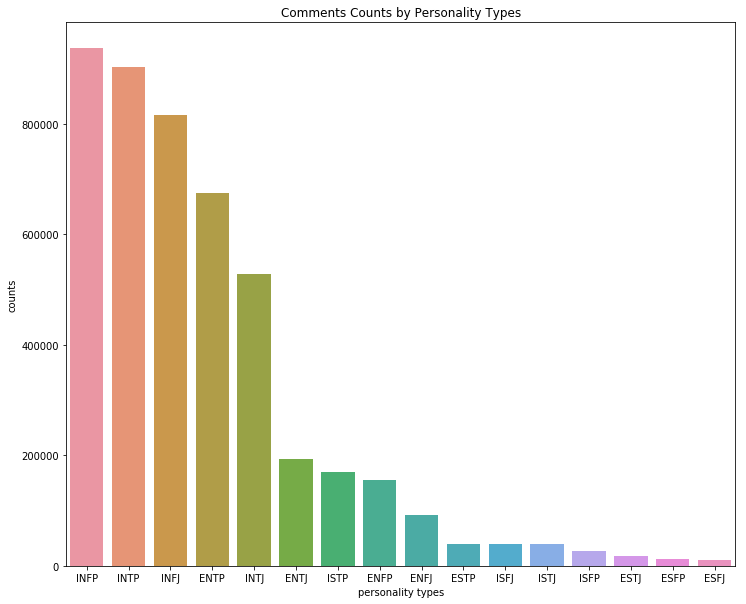

In [160]:
plt.figure(figsize=(12,10))
sns.countplot(data=df, x='MBTI', order = df['MBTI'].value_counts().index)
plt.xlabel('personality types')
plt.ylabel('counts')
plt.title('Comments Counts by Personality Types')

From the above graph we can see that INFP, INTP, INFJ, ENTP and INTJ contribute the most comments in our set. This reflects the nature of Reddit and even the distribution of these types in the population, however, the imbalance of the data is not great for our model. Therefore, I decide to keep one block of the data from the first 5 personalities and use data from the rest of the files to upsample the rest of the personality types. 

I put the previous feature engineering and filter steps into a script and iterated over all files to get more data for the remaining personality types and generated one df/csv in the end. 

**Script below**

In [ ]:
# script to upsample the data from other data blocks 

import pandas as pd
import numpy as np
import sys

# read in a block of data
df = pd.read_csv(sys.argv[1])

# drop missing value
df = df.dropna().copy()

# extract MBTI from flair text
import re

mbti = ['INFP','INFJ','INTP','INTJ','ENTP','ENFP','ISTP','ISFP','ENTJ','ISTJ','ENFJ','ISFJ','ESTP','ESFP','ESFJ','ESTJ']
pat = '|'.join(r"\b{}\b".format(x) for x in mbti)

df['personality'] = df['flair_text'].str.findall(pat, flags=re.I).str.join(' ')

# transform text in personality column to all upper case
df['personality'] = df['personality'].str.upper()

# split the first MBTI indicator from the rest
new = df['personality'].str.split(' ', n=1, expand=True)

# rename the sub df
new.columns=['first','second']

# add the separated MBTI to the main dataframe
df['MBTI'] = new['first']

# drop the personality column and rename all the columns
df = df.drop('personality', axis=1)

# rename the columns
df.columns = ['flair','comments','subreddit','username','MBTI']

# select personalities we want to keep
mbti_selection = ['ENFP','ISTP','ISFP','ENTJ','ISTJ','ENFJ','ISFJ','ESTP','ESFP','ESFJ','ESTJ']
# above selection is adjusted according to how many data points there are

df_sub = df[df['MBTI'].isin(mbti_selection)].copy().reset_index()

# save to new csv file
df_sub.to_csv(sys.argv[2])

Use the scripts below, I was able to generate multiple csv files, below I read in them into one dataframe, which is the master dataframe I use for the remainder of the project.

### Read in multiple files 

In [2]:
# read in multiple files 
import glob

datafiles = glob.glob('../original_data/mbti_reddit_clean*.csv') #the * is a wildcard

datafiles.sort() # must have this line to sort the names 

print(datafiles)

['../original_data/mbti_reddit_clean1.csv', '../original_data/mbti_reddit_clean10.csv', '../original_data/mbti_reddit_clean11.csv', '../original_data/mbti_reddit_clean12.csv', '../original_data/mbti_reddit_clean13.csv', '../original_data/mbti_reddit_clean14.csv', '../original_data/mbti_reddit_clean15.csv', '../original_data/mbti_reddit_clean16.csv', '../original_data/mbti_reddit_clean17.csv', '../original_data/mbti_reddit_clean18.csv', '../original_data/mbti_reddit_clean2.csv', '../original_data/mbti_reddit_clean3.csv', '../original_data/mbti_reddit_clean4.csv', '../original_data/mbti_reddit_clean5.csv', '../original_data/mbti_reddit_clean6.csv', '../original_data/mbti_reddit_clean7.csv', '../original_data/mbti_reddit_clean9.csv']


In [3]:
# concat multiple files into one 
df_new = pd.concat((pd.read_csv(f, lineterminator='\n') for f in datafiles))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [4]:
# check rows and shape 
df_new.shape

(3004071, 7)

In [5]:
df_new.head(n=50) # I forgot to set index_col here, have to clean the index mess

,MBTI,Unnamed: 0,comments,flair,index,subreddit,username
0,INFP,0,Lol that's why I left.,INFP: The Dreamer Senpai,NaN,entp,LadyBanterbury
1,INTP,1,"I was just about to post ""I try telling people...",INTP: The Theorist,NaN,INTP,Finarin
2,INFP,2,My first thought was Pepsi or something. Proba...,INFP: The Dreamer,NaN,WTF,xanplease
3,ENTP,3,"Not if the formula is something like ""every ti...","ENTP: Antisocial Extrovert, Rational Eccentric",NaN,youtubehaiku,HeirToGallifrey
4,INTP,4,Does this imply I'm a five now?,INTP/18/m/blankly staring at you,NaN,entp,lightfive
5,INTP,5,"Well, I wouldn't know but I think there's a lo...",INTP: The Theorist,NaN,InternetIsBeautiful,ElementalVoltage
6,INFJ,6,"sine na, support the directors, actors and oth...",The INFJ Dude,NaN,Philippines,BabyFlo70
7,INFP,7,I use just enough vacation days so that I don'...,Honorary INFP; INTP/21/F,NaN,tumblr,RockinSocksReborn
8,INTP,8,Can be ur angle... or you're devil ;),intp or something of the sort,NaN,woof_irl,crowbird_
9,INTP,9,I mean we don't how much influence Crow has on...,INTP/23/F,NaN,RWBY,RockinSocksReborn


### Missing Values

In [6]:
# Check missing values
df_new.isna().sum()

MBTI             3289
Unnamed: 0          0
comments            0
flair               0
index         1555087
subreddit           0
username            0
dtype: int64

In [7]:
# drop 2 duplicated index column 
df_new = df_new.drop(['index','Unnamed: 0'], axis=1).copy()

In [8]:
# check for missing values again.
df_new.isna().sum()

MBTI         3289
comments        0
flair           0
subreddit       0
username        0
dtype: int64

In [9]:
# drop the rows with null body text 
df_clean = df_new.dropna().copy()

In [10]:
df_clean.isna().sum()

MBTI         0
comments     0
flair        0
subreddit    0
username     0
dtype: int64

In [11]:
# save df to a csv for later use
df_clean.to_csv('df_clean.csv')

### Some simple EDA

In [12]:
df_clean['MBTI'].value_counts() # final dataframe value counts

INFP    312220
INTP    301236
INFJ    271994
ENTJ    257355
ISTP    226154
ENTP    224612
ENFP    206537
ENFJ    182589
INTJ    176802
ESTP    161173
ISFJ    157556
ISTJ    155944
ISFP    142215
ESTJ     96501
ESFP     67022
ESFJ     60872
Name: MBTI, dtype: int64

Text(0.5, 1.0, 'Comments Counts by Personality Types')

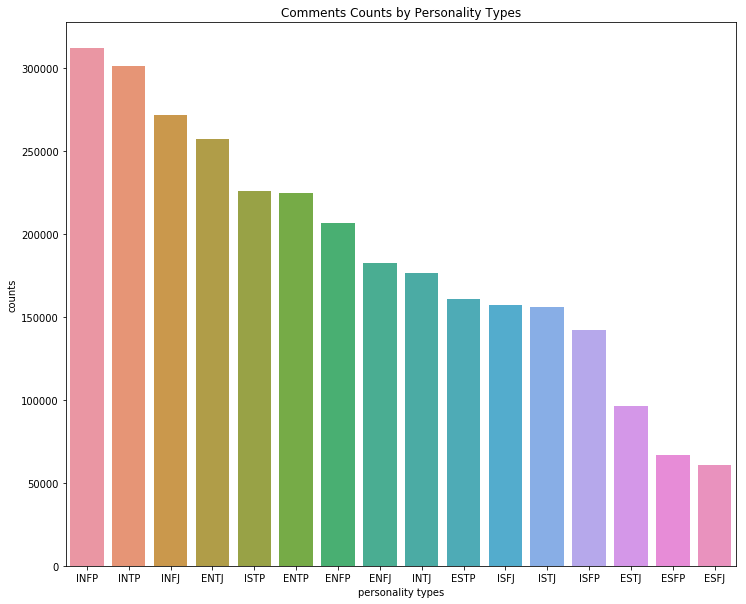

In [13]:
plt.figure(figsize=(12,10))
sns.countplot(data=df_clean, x='MBTI', order = df_clean['MBTI'].value_counts().index)
plt.xlabel('personality types')
plt.ylabel('counts')
plt.title('Comments Counts by Personality Types')

In [14]:
# get the comments length of each comment
df_clean['comments length'] = df_clean['comments'].str.len()

In [16]:
# calculate the avg length of the comments and sort from longest to shortest
df_avglength = pd.DataFrame(df_clean.groupby(['MBTI'])['comments length'].mean())
df_avglength = df_avglength.sort_values(['comments length'], ascending=False)
df_avglength

,comments length
MBTI,
ESFJ,282.256160
ISTP,261.368930
ESTJ,248.995741
INTJ,245.320098
ISFP,245.061442
INFJ,234.872556
ENFJ,226.650664
ENTP,221.916367
ISFJ,221.864689


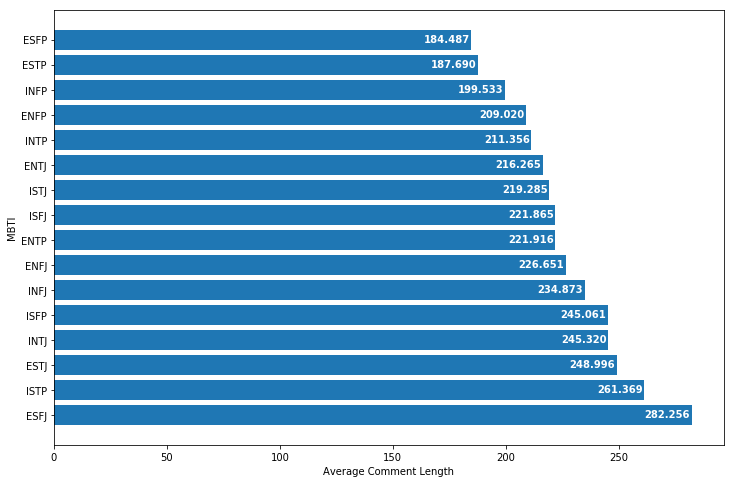

In [17]:
# visualise the comments length in bar graph
plt.figure(figsize=(12,8))
ax = plt.subplot()
plt.barh(df_avglength.index,df_avglength['comments length'])
plt.xlabel('Average Comment Length')
plt.ylabel('MBTI')
for i, v in enumerate(df_avglength['comments length']):
    ax.text(v-21, i - 0.1, f'{v:.3f}', color='white', fontweight='bold')
plt.show()

### Dropping Redundant Columns 

In [15]:
# drop the redundant columns 
df_clean_comments = df_clean.drop(['flair','subreddit','username','comments length'],axis=1)

In [16]:
# save it as new csv to be used later
df_clean_comments.to_csv('comments_mbti.csv')

In [17]:
df_clean_comments.shape

(3000782, 2)

## Text Processing 

In [19]:
df_clean_comments.dtypes

MBTI        object
comments    object
dtype: object

In [49]:
# import nltk packages: stopwords, stemmer and tokenizer
import nltk 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Doylism/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [23]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

**Generate a random sample df to test functions** 

Due to the size of the data, I usually generate a random sample df to test functions before applying it onto the complete dataset.

In [83]:
# subset a small amount of data to test the function 
df_test = df_clean_comments.sample(n=100, random_state=1)

In [58]:
# convert comments to lower strings
df_test['comments'] = df_test['comments'].str.lower()

### Remove numbers 

In [59]:
# remove numbers 
import re 
df_test['comments'] = df_test['comments'].apply(lambda x: re.sub(r'\d+', '', x))

### Remove punctuations

In [60]:
# remove punctuations 
def remove_punc(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [61]:
# remove punctuation 
df_test['comments'] = df_test['comments'].apply(lambda x: remove_punc(x))

In [62]:
# Check the output in sample set 
df_test

,MBTI,comments
20945,ISFP,heh heh dont worry im sure everyone will be re...
593841,INFJ,like the others have been suggesting in this t...
176580,ISTP,i was reading a great collection of poe storie...
173917,ENFP,if you insist
1447863,ENTJ,ah so thats what happened to my schools audito...
...,...,...
59903,ISFP,i just apologize after that it is a bad habit ...
94820,ESTP,ive been really interested in glitchy reality ...
1335732,INTJ,and d sounds a lot more like te than ti so get...
1222128,INFP,oh yeah all my color normal friends are strugg...


### Remove Stop Words

In [63]:
def remove_stop(text):
    tokens = word_tokenize(text)
    text = [i for i in tokens if not i in stop_words]
    return text

In [64]:
# remove stop words
df_test['comments'] = df_test['comments'].apply(lambda x: remove_stop(x))

In [65]:
# check out sample set 
df_test

,MBTI,comments
20945,ISFP,"[heh, heh, dont, worry, im, sure, everyone, re..."
593841,INFJ,"[like, others, suggesting, thread, knowing, fi..."
176580,ISTP,"[reading, great, collection, poe, stories, rec..."
173917,ENFP,[insist]
1447863,ENTJ,"[ah, thats, happened, schools, auditorium, uth..."
...,...,...
59903,ISFP,"[apologize, bad, habit, mine, anal, random, fa..."
94820,ESTP,"[ive, really, interested, glitchy, reality, st..."
1335732,INTJ,"[sounds, lot, like, te, ti, get, way, peasants]"
1222128,INFP,"[oh, yeah, color, normal, friends, struggling,..."


### A combined function 

Based on the test on the sample set, I combined the steps to 2 functions, and then apply it to the complete dataset.

In [82]:
# remove punctuations 
def remove_punc(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

# everything else 
def preprocess(text):
    # convert to lower case
    text = text.lower()
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove stop words
    text = ' '.join(word for word in text.split() if not word in stop_words)
    return text 

#### Test on sample dataset

In [84]:
df_test['comments'] = df_test['comments'].apply(lambda x: remove_punc(x))

In [85]:
df_test['comments'] = df_test['comments'].apply(lambda x: preprocess(x))

In [86]:
df_test

,MBTI,comments
20945,ISFP,heh heh dont worry im sure everyone really imp...
593841,INFJ,like others suggesting thread knowing first si...
176580,ISTP,reading great collection poe stories recently ...
173917,ENFP,insist
1447863,ENTJ,ah thats happened schools auditorium utheeman
...,...,...
59903,ISFP,apologize bad habit mine anal random facts num...
94820,ESTP,ive really interested glitchy reality stuff la...
1335732,INTJ,sounds lot like te ti get way peasants
1222128,INFP,oh yeah color normal friends struggling dark s...


#### Apply on complete dataset

In [87]:
df_clean_comments['comments'] = df_clean_comments['comments'].apply(lambda x: remove_punc(x))

In [88]:
df_clean_comments['comments'] = df_clean_comments['comments'].apply(lambda x: preprocess(x))
df_clean_comments.head()

,MBTI,comments
0,INFP,lol thats left
1,INTP,post try telling people time im always joking ...
2,INFP,first thought pepsi something probably alcohol
3,ENTP,formula something like every time says add bpm...
4,INTP,imply im five


In [90]:
df_clean_comments['comments'].apply(lambda x: len(x.split(' '))).sum()
# 61 millions words!!! 

61310757

In [10]:
df_clean_comments.isna().sum()

MBTI            0
comments    23971
dtype: int64

In [11]:
# drop the null values
df_clean_comments = df_clean_comments.dropna()

In [12]:
df_clean_comments.isna().sum()

MBTI        0
comments    0
dtype: int64

In [13]:
df_clean_comments.shape
# now we are left with 2.97 million of comments 

(2976811, 2)

--- 

## Simple Models
### Split the data

In [93]:
from sklearn.model_selection import train_test_split

X = df_clean_comments['comments']
y = df_clean_comments['MBTI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

### Models

#### Naive Bayes Classifier 

In [98]:
mbti = ['INFP','INFJ','INTP','INTJ','ENTP','ENFP','ISTP','ISFP','ENTJ','ISTJ','ENFJ','ISFJ','ESTP','ESFP','ESFJ','ESTJ']

In [94]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# build a pipeline for tfidf and clasify the data 
my_nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])
my_nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [99]:
from sklearn.metrics import classification_report
y_pred = my_nb.predict(X_test)

print('accuracy %s' % my_nb.score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=mbti))

accuracy 0.169956733519581
              precision    recall  f1-score   support

        INFP       0.56      0.06      0.11     54722
        INFJ       0.45      0.04      0.07     61954
        INTP       0.24      0.14      0.18     77590
        INTJ       0.35      0.06      0.10     67486
        ENTP       0.95      0.01      0.02     18218
        ENFP       0.78      0.01      0.01     19938
        ISTP       0.76      0.03      0.05     28912
        ISFP       0.63      0.09      0.15     48281
        ENTJ       0.17      0.22      0.19     81229
        ISTJ       0.13      0.58      0.21     93610
        ENFJ       0.55      0.02      0.05     53255
        ISFJ       0.14      0.40      0.21     90431
        ESTP       0.62      0.05      0.09     47188
        ESFP       0.72      0.07      0.14     42873
        ESFJ       0.60      0.03      0.05     46841
        ESTJ       0.45      0.17      0.25     67707

   micro avg       0.17      0.17      0.17    900235

We can see that because of the imbalance of the data, the precision/recall are highly imbalanced, resulting in low f1-scores. 

#### SGD Classifier

In [102]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier(loss='hinge', penalty='l2', \
                                random_state=42, max_iter=5, tol=None))
])

sgd.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...dom_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [103]:
y_pred = sgd.predict(X_test)

print('accuracy %s' % sgd.score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=mbti))

accuracy 0.18061172915960833
              precision    recall  f1-score   support

        INFP       0.18      0.23      0.20     54722
        INFJ       0.17      0.14      0.15     61954
        INTP       0.18      0.18      0.18     77590
        INTJ       0.16      0.15      0.16     67486
        ENTP       0.25      0.18      0.21     18218
        ENFP       0.23      0.22      0.22     19938
        ISTP       0.28      0.30      0.29     28912
        ISFP       0.22      0.28      0.25     48281
        ENTJ       0.16      0.18      0.17     81229
        ISTJ       0.17      0.13      0.15     93610
        ENFJ       0.15      0.12      0.13     53255
        ISFJ       0.16      0.16      0.16     90431
        ESTP       0.18      0.20      0.19     47188
        ESFP       0.27      0.24      0.25     42873
        ESFJ       0.17      0.18      0.17     46841
        ESTJ       0.28      0.27      0.28     67707

   micro avg       0.19      0.19      0.19    9002

SGD Classifier performs a little better than Naive Bayes, but we still want to find out about other classifiers. 

#### Logistic Regression 

In [104]:
from sklearn.linear_model import LogisticRegression

my_logit = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression(solver='saga'))
])
my_logit.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


KeyboardInterrupt: 

In [ ]:
y_pred = my_logit.predict(X_test)

print('accuracy %s' % my_logit.score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=mbti))

Logistic Regression result is keyboard interrupted because it's taking some time to process, and at this point, I was researching into SpaCy and decided to use SpaCy to reprocess the text and then fit in the model. 

---

## SpaCy Text Processing

To use SpaCy, I re-imported a version of the dataset before it's processed using NLTK. 


In [8]:
# import data 
df_punc = pd.read_csv('../../clean_data/with_punc.csv', index_col=0)

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [25]:
# as I did before, I created a sample set from the complete set to test the functions. 
df_sample = df_punc.sample(n=1000)

In [10]:
df_sample

,MBTI,comments
1533251,INFP,"Also, this is availble on jailbroken iPhones a..."
489172,INFP,Damn spices eating all my jeans!
1434585,INFP,When my friend first showed me a picture of th...
979964,INFP,Lovely
50650,ENFJ,I have impressed the guy who taught me not to ...
...,...,...
1265,ESTP,Asian American History: Movement and Dislocati...
122703,ENTJ,I'm not saying that all media is bad all of th...
1101969,INTP,Carthage. Spam cities and pick up that +2 Scie...
61720,ESTJ,Redditors


In [3]:
# check missing values
df_punc.isna().sum()

# good there is no null value

MBTI        0
comments    0
dtype: int64

In [4]:
X = df_punc.comments
y = df_punc.MBTI

In [5]:
# split the data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Text Processing in SpaCy

In [11]:
import spacy

# Load the English NLP model
nlp = spacy.load('en_core_web_sm')

# function to return tokens that are not punctuation, space, 
# stop-words, url, emails and are longer than 2 letters.
def token_filter(token):
    return not (token.is_punct | token.is_space | token.is_stop | len(token.text) <= 2 | token.like_email | token.like_url)

In [61]:
# function for text processing 
def clean_text(docs): 
    filtered_tokens = []
    
    for doc in nlp.pipe(docs):
        # lemmatisation 
        tokens = [token.lemma_ for token in doc if token_filter(token) ]
        # lower case
        tokens = [word.lower() for word in tokens]
        # delete all the lemmatised pronoun placeholder
        tokens = [word for word in tokens if word != '-pron-']
        # remove urls 
        tokens = [re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'url', word) for word in tokens]
        # keep only words
        tokens = [re.sub("[^a-zA-Z]", " ", word) for word in tokens]
        # remove extra white spaces
        tokens = [re.sub(' +', ' ', word) for word in tokens]
        filtered_tokens.append(tokens)
    return filtered_tokens

#### Try on the sample set 

In [60]:
df_sample['text_lemma'] = clean_text(df_sample['comments'])
df_sample['text_lemma'] = df_sample['text_lemma'].apply(lambda x: ' '.join(x))

In [27]:
df_sample
#pd.set_option('display.max_colwidth', -1)

,MBTI,comments,text_lemma
787840,ISTP,"It's not quite that simple. The ""test taking"" environment is completely different to day-to-day stuff. Dead silence, no referencing/quick checks which I do constantly (to reaffirm my knowledge), the stress of trying to get a good grade, being tested on the spot, having a time limit, etc. It impairs (at least my) ability to remember things. But just get me out of the blue when I'm completely relaxed and there's no stress or anything? Sure, I could easily tell you. Also, the questions on exams are usually different than how you'd usually use the knowledge as well as different from how you learned it. Also, some people are just shit at thoroughly making sure that the knowledge is down on paper. Sometimes you forget to mention something that the other person would simply just follow up on and ask about, which you'd then respond. On a test, that doesn't happen, you just get points knocked off.",be not quite that simple the test take environment be completely different to day to day stuff dead silence no referencing quick check which do constantly to reaffirm knowledge the stress of try to get good grade be test on the spot have time limit etc impair at least ability to remember thing but just get out of the blue when be completely relaxed and there be no stress or anything sure could easily tell also the question on exam be usually different than how would usually use the knowledge as well as different from how learn also some people be just shit at thoroughly make sure that the knowledge be down on paper sometimes forget to mention something that the other person would simply just follow up on and ask about which would then respond on test that do not happen just get point knock off
46144,ISTJ,"For those who haven't been in touch with the game for long or very closely (including the creator of this video I assume), in the past we have had multiple news agencies blow up at Arma 3 for being an ""ISIS training simulator"" because of a mod that added ISIS units. Don't let this happen again. Please remove this for the sake of the game.",for those who have not be in touch with the game for long or very closely include the creator of this video assume in the past have have multiple news agency blow up at arma for be an isis training simulator because of mod that add isis unit do not let this happen again please remove this for the sake of the game
321942,ENTP,"The fat toothless kid from *Stranger Things*. He seems to be the only one of the kids who has a grasp of the bigger picture. He starts off as more of a sidekick until the other two kids start to lose it, then he steps from out of the shadows, smacks them around until they see sense, and gets everything back on track.",the fat toothless kid from stranger things seem to be the only one of the kid who have grasp of the big picture start off as more of sidekick until the other two kid start to lose then step from out of the shadow smack around until see sense and get everything back on track
123281,ENFP,"I wasn't allowed to wear nail polish, get natural-colored highlights, wear makeup (even to cover a zit), or have any piercing besides one normal-sized love at my school.",be not allow to wear nail polish get natural color highlight wear makeup even to cover zit or have any piercing besides one normal sized love at school
263516,ISFJ,"She's been off the grid for what...like a month? Two months? No one in the fandom knows where she is or what she's doing right now. It doesn't surprise me that she didn't go and I'm not sure why everyone is so upset about it. I feel like if she did go, it would have been all over the news (because the media is obsessed with her), then people would be saying ""Ugh, why is Taylor Swift making the women's march all about her?"" Girl can't win. Not to mention the fact that she has all kinds of psychos who stalk her and doesn't go anywhere without security...all that plus the paparazzi would have created a huge spectacle

#### Apply on the complete set

In [ ]:
# apply the function to the complete set 
df_punc['comments_lemma'] = clean_text(df_punc['comments'])
df_punc['comments_lemma'] = df_punc['comments_lemma'].apply(lambda x: ' '.join(x))

In [ ]:
df_punc.to_csv('spacy_clean.csv') # cleaned data saved as checkpoint

Above 2 commands were executed on AWS and a cleaned data file was generated in the end. 

### Explore Bag of Words 

In [89]:
# Load in the cleaned data into a dataframe
df_clean = pd.read_csv('../../clean_data/spacy_clean.csv', index_col=0)

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [90]:
df_clean.head()

,MBTI,comments,comments_lemma
0,INFP,Lol that's why I left.,lol that be why leave
1,INTP,"I was just about to post ""I try telling people...",be just about to post try tell people all the ...
2,INFP,My first thought was Pepsi or something. Proba...,first thought be pepsi or something probably n...
3,ENTP,"Not if the formula is something like ""every ti...",not if the formula be something like every tim...
4,INTP,Does this imply I'm a five now?,do this imply be five now


In [91]:
df_clean.isna().sum()

MBTI                  0
comments              0
comments_lemma    23125
dtype: int64

In [92]:
df_clean = df_clean.dropna()

In [93]:
# remove the digits and replace with white space 
pattern = '[0-9]'

df_clean['comments_lemma'] = df_clean['comments_lemma'].apply(lambda x: re.sub(pattern,' ', x))

# remove underscore 
df_clean['comments_lemma'] = df_clean['comments_lemma'].apply(lambda x: x.replace('_',' '))

In [94]:
# split the data 
X = df_clean['comments_lemma']
y = df_clean['MBTI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, stratify=y)

In [95]:

bagofwords = CountVectorizer(min_df=50, stop_words='english')
bagofwords.fit(X_train)
X_train_dtm = bagofwords.transform(X_train)
X_test_dtm = bagofwords.transform(X_test)

In [96]:
X_train_dtm.shape

(2084359, 23766)

In [97]:
bagofwords.get_feature_names()[0:50]

['aa',
 'aaa',
 'aaaaaand',
 'aaaaand',
 'aaaand',
 'aaah',
 'aaand',
 'aac',
 'aah',
 'aan',
 'aang',
 'aaron',
 'aaryn',
 'aas',
 'ab',
 'aback',
 'abandon',
 'abandonment',
 'abbey',
 'abbott',
 'abbreviate',
 'abbreviation',
 'abby',
 'abc',
 'abdoman',
 'abdominal',
 'abduct',
 'abduction',
 'abe',
 'abed',
 'abel',
 'aber',
 'aberration',
 'abh',
 'abhor',
 'abhorrent',
 'abide',
 'abilify',
 'ability',
 'abit',
 'abject',
 'able',
 'ableist',
 'ableton',
 'abnormal',
 'abnormality',
 'abnormally',
 'aboard',
 'abolish',
 'abolition']

## Models & Grid Search 


### Simple Models 

#### Logistic Regression

In [11]:
my_logit = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression(solver='saga'))
])
my_logit.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False))])

In [12]:
y_pred = my_logit.predict(X_test)

print('accuracy %s' % my_logit.score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=mbti))

accuracy 0.21202443081703978
              precision    recall  f1-score   support

        INFP       0.29      0.19      0.23     54111
        INFJ       0.24      0.13      0.16     61347
        INTP       0.19      0.22      0.21     76910
        INTJ       0.22      0.15      0.17     67002
        ENTP       0.32      0.16      0.21     18045
        ENFP       0.39      0.14      0.20     20097
        ISTP       0.40      0.24      0.30     28820
        ISFP       0.31      0.23      0.26     47966
        ENTJ       0.18      0.23      0.20     80672
        ISTJ       0.15      0.30      0.20     93057
        ENFJ       0.26      0.10      0.15     53023
        ISFJ       0.16      0.29      0.20     89188
        ESTP       0.30      0.15      0.20     47095
        ESFP       0.38      0.21      0.27     42376
        ESFJ       0.29      0.14      0.19     46437
        ESTJ       0.26      0.32      0.29     67152

   micro avg       0.21      0.21      0.21    8932

Results are much better than before when we had the messier data. 

#### Logistic Regression - n-gram

Trying to use n-gram but my computer could not handle this, I will be use n-grams later directly in TFIDFVecotrizer.

In [34]:
my_logit = Pipeline([
    ('vect', CountVectorizer(min_df=20, stop_words='english',ngram_range = (1,3))),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression(solver='saga'))
])
my_logit.fit(X_train, y_train)

MemoryError: 

In [ ]:
y_pred = my_logit.predict(X_test)

print('accuracy %s' % my_logit.score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=mbti))

#### Naive Bayes 

In [13]:
# build a pipeline for vectorise, transform and clasify the data 
my_nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])
my_nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [14]:
y_pred = my_nb.predict(X_test)

print('accuracy %s' % my_nb.score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=mbti))

accuracy 0.1685495769608798
              precision    recall  f1-score   support

        INFP       0.57      0.06      0.11     54111
        INFJ       0.43      0.04      0.08     61347
        INTP       0.23      0.14      0.17     76910
        INTJ       0.36      0.05      0.09     67002
        ENTP       0.90      0.01      0.01     18045
        ENFP       0.74      0.01      0.01     20097
        ISTP       0.73      0.03      0.05     28820
        ISFP       0.58      0.08      0.14     47966
        ENTJ       0.17      0.22      0.19     80672
        ISTJ       0.13      0.56      0.21     93057
        ENFJ       0.53      0.03      0.05     53023
        ISFJ       0.14      0.42      0.21     89188
        ESTP       0.59      0.04      0.08     47095
        ESFP       0.69      0.07      0.13     42376
        ESFJ       0.59      0.03      0.06     46437
        ESTJ       0.43      0.16      0.24     67152

   micro avg       0.17      0.17      0.17    89329

#### SGD Classifier 

In [15]:
sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier(loss='hinge', penalty='l2', \
                                random_state=42, max_iter=5, tol=None))
])

sgd.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...dom_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [16]:
y_pred = sgd.predict(X_test)

print('accuracy %s' % sgd.score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=mbti))

accuracy 0.1781633900445316
              precision    recall  f1-score   support

        INFP       0.18      0.22      0.20     54111
        INFJ       0.18      0.12      0.14     61347
        INTP       0.18      0.15      0.16     76910
        INTJ       0.14      0.17      0.16     67002
        ENTP       0.19      0.18      0.18     18045
        ENFP       0.20      0.19      0.19     20097
        ISTP       0.23      0.29      0.26     28820
        ISFP       0.19      0.26      0.22     47966
        ENTJ       0.15      0.16      0.16     80672
        ISTJ       0.15      0.18      0.16     93057
        ENFJ       0.16      0.11      0.13     53023
        ISFJ       0.16      0.10      0.13     89188
        ESTP       0.16      0.20      0.18     47095
        ESFP       0.24      0.21      0.22     42376
        ESFJ       0.20      0.14      0.16     46437
        ESTJ       0.23      0.29      0.25     67152

   micro avg       0.18      0.18      0.18    89329

### Grid Search 

Following the results from the above models, I decided to use Grid Search to test more models and find best parameters.

Because of the size of the data, the computation, even on a high power AWS instance, it still took a long time, therefore I decided to use a sample set to find the parameters for best models and then fit to the complete set. I understand this might not be the best practice here, I would love to improve this in the future. 

#### try on a sample set

In [28]:
df_test = df_clean.sample(n=2000)
X_trial = df_test['comments_lemma']
y_trial = df_test['MBTI']

In [29]:
X_trial_train, X_trial_test, y_trial_train, y_trial_test = train_test_split(X_trial, y_trial, test_size=0.3, stratify=y_trial, random_state=42)

In [32]:
pipeline = Pipeline([ ('vect', CountVectorizer()),('model', LogisticRegression())])

param_grid = [
    # Logistic Regression
    {'vect':[TfidfVectorizer()], 'model':[LogisticRegression(solver='saga')],
    'model__penalty':['l1','l2'], 'model__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'vect__min_df':[50, 100, 300, 500], 'vect__smooth_idf': (True, False),
     'vect__norm': ('l1', 'l2', None)},
    
    # Random Forest
    {'vect':[TfidfVectorizer()], 'model':[RandomForestClassifier()],
     'vect__min_df':[50, 100, 300, 500], 
     'model__n_estimators': [50, 100, 150, 200], 'model__max_depth':[2, 5, 10, 15, 20],
     'vect__smooth_idf': (True, False), 'vect__norm': ('l1', 'l2', None)},
    
    # XG Boost
    {'vect':[TfidfVectorizer()], 'model':[XGBClassifier()],
     'vect__min_df':[50, 100, 300, 500], 'model__learning_rate': [0.1, 0.5, 1, 2],
     'model__n_estimators': [50, 100, 150, 200], 'model__max_depth':[2, 5, 10, 15, 20],
     'vect__smooth_idf': (True, False), 'vect__norm': ('l1', 'l2', None)},
    
    # SGD Classifier
    {'vect':[TfidfVectorizer()], 
     'model':[SGDClassifier(n_iter=1000, loss='hinge',penalty='l2',random_state=42, max_iter=5, tol=None)],
     'vect__min_df':[50, 100, 300, 500],'model__alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
     'vect__smooth_idf': (True, False), 'vect__norm': ('l1', 'l2', None)}
]

grid = GridSearchCV(pipeline, param_grid, cv=5, verbose=10, n_jobs=-1)
fittedgrid = grid.fit(X_trial_train, y_trial_train)

fittedgrid.score(X_trial_test, y_trial_test)

# save the best model as a pkl
joblib.dump(fittedgrid.best_estimator_, 'bestmodel.pkl', compress = 1)

Fitting 5 folds for each of 2904 candidates, totalling 14520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 229 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  

['bestmodel.pkl']

In [36]:
# look at the parameters of the best model
fittedgrid.best_estimator_

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=50,
        ngram_range=(1, 1), norm='l1', preprocessor=None, smooth_idf=False...penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False))])

In [34]:
# put the grid results into a dataframe
grid_results = pd.concat([pd.DataFrame(fittedgrid.cv_results_["params"]),pd.DataFrame(fittedgrid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1).sort_values(by='Accuracy', ascending = False)

In [43]:
grid_results.head(10)

,model,model__C,model__alpha,model__learning_rate,model__max_depth,model__n_estimators,model__penalty,vect,vect__min_df,vect__norm,vect__smooth_idf,Accuracy
434,"RandomForestClassifier(bootstrap=True, class_w...",NaN,NaN,NaN,5.0,50.0,NaN,"TfidfVectorizer(analyzer='word', binary=False,...",50,l2,True,0.120000
169,"LogisticRegression(C=1, class_weight=None, dua...",1.0,NaN,NaN,NaN,NaN,l2,"TfidfVectorizer(analyzer='word', binary=False,...",50,l1,False,0.120000
339,"RandomForestClassifier(bootstrap=True, class_w...",NaN,NaN,NaN,2.0,50.0,NaN,"TfidfVectorizer(analyzer='word', binary=False,...",50,l2,False,0.119286
168,"LogisticRegression(C=1, class_weight=None, dua...",1.0,NaN,NaN,NaN,NaN,l2,"TfidfVectorizer(analyzer='word', binary=False,...",50,l1,True,0.119286
410,"RandomForestClassifier(bootstrap=True, class_w...",NaN,NaN,NaN,2.0,200.0,NaN,"TfidfVectorizer(analyzer='word', binary=False,...",50,l2,True,0.117143
362,"RandomForestClassifier(bootstrap=True, class_w...",NaN,NaN,NaN,2.0,100.0,NaN,"TfidfVectorizer(analyzer='word', binary=False,...",50,l2,True,0.117143
150,"LogisticRegression(C=1, class_weight=None, dua...",1.0,NaN,NaN,NaN,NaN,l1,"TfidfVectorizer(analyzer='word', binary=False,...",100,l1,True,0.117143
151,"LogisticRegression(C=1, class_weight=None, dua...",1.0,NaN,NaN,NaN,NaN,l1,"TfidfVectorizer(analyzer='word', binary=False,...",100,l1,False,0.117143
504,"RandomForestClassifier(bootstrap=True, class_w...",NaN,NaN,NaN,5.0,200.0,NaN,"TfidfVectorizer(analyzer='word', binary=False,...",50,l1,True,0.117143
483,"RandomForestClassifier(bootstrap=True, class_w...",NaN,NaN,NaN,5.0,150.0,NaN,"TfidfVectorizer(analyzer='word', binary=False,...",50,l2,False,0.115714


In [38]:
results = pd.DataFrame(fittedgrid.cv_results_)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, *

In [40]:
# best model no.1 
results['param_model'].iloc[434]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
# best model no.2
results['param_model'].iloc[169]

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

#### Apply the 2 best models on complete set

In [ ]:
# use 2 best models to form a new pipeline and fit to the train set 

pipeline1 = Pipeline([ ('vect', CountVectorizer()),('model', LogisticRegression())])

param_grid1 = [
    # Logistic Regression
    {'vect':[TfidfVectorizer(smooth_idf=False, norm='l1')], 
     'model':[LogisticRegression(solver='saga', penalty='l2', C=1.0)],
     'vect__min_df':[100, 500, 1000, 2500]},
    
    # Random Forest
    {'vect':[TfidfVectorizer(smooth_idf=True, norm='l2')], 
     'model':[RandomForestClassifier(n_estimators=50, max_depth=5)],
     'vect__min_df':[100, 500, 1000, 2500]},
]

grid1 = GridSearchCV(pipeline1, param_grid1, cv=5, verbose=10, n_jobs=-1)
fittedgrid1 = grid1.fit(X_train, y_train)

fittedgrid1.score(X_test, y_test)

# save the best model to file
joblib.dump(fittedgrid1.best_estimator_, 'bestmodel1.pkl', compress = 1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done   4 out of  40 | elapsed:  4.2min remaining: 38.0min
[Parallel(n_jobs=-1)]: Done   9 out of  40 | elapsed:  4.7min remaining: 16.2min
[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:  5.2min remaining:  9.6min
[Parallel(n_jobs=-1)]: Done  19 out of  40 | elapsed:  5.6min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  24 out of  40 | elapsed: 11.9min remaining:  8.0min
[Parallel(n_jobs=-1)]: Done  29 out of  40 | elapsed: 12.2min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed: 13.1min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 14.1min finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this wa

In [51]:
# load in the model
best_model = joblib.load('bestmodel1.pkl')

In [56]:
# accuracy score
score = best_model.score(X_test, y_test)
score

0.1551844961032041

In [57]:
y_pred = best_model.predict(X_test)

In [58]:
print(classification_report(y_test, y_pred,target_names=mbti))

              precision    recall  f1-score   support

        INFP       0.24      0.05      0.09     54285
        INFJ       0.21      0.04      0.07     61493
        INTP       0.16      0.17      0.17     76631
        INTJ       0.23      0.06      0.10     66850
        ENTP       0.18      0.01      0.02     18089
        ENFP       0.31      0.02      0.04     19968
        ISTP       0.31      0.04      0.07     28800
        ISFP       0.31      0.11      0.16     47842
        ENTJ       0.14      0.20      0.17     81078
        ISTJ       0.13      0.43      0.20     92909
        ENFJ       0.31      0.03      0.05     52665
        ISFJ       0.13      0.35      0.19     89567
        ESTP       0.30      0.05      0.08     46968
        ESFP       0.44      0.07      0.12     42411
        ESFJ       0.24      0.02      0.04     46478
        ESTJ       0.24      0.19      0.21     67264

   micro avg       0.16      0.16      0.16    893298
   macro avg       0.24   

Interestingly the result is worse than Logistic Regression... 

To classify user comments to personality types are difficult, with 16 classes, random guessing would have an accuracy about 7%, the best model we tried is Logistic Regression, with precision/recall/f1 score all above 20%. 

However, I was not satisfied at that time, so I tried more approaches, including balancing the data, buillding LDA topic models. 

## Dealing with Imbalanced Data 

### Remove more stop words!

While I was working on building dictionary using Gensim, I found out that there are actually more stop words and spaces that are not cleaned in the documents, so I performed more cleaning steps here (*sigh*). 

In [8]:
# list of posts 
[p.split('|||') for p in df_clean.head(1).comments_lemma.values]

[['lol that be why leave']]

In [11]:
# convert columns to list 

list_personality = df_clean['MBTI'].tolist()
list_posts = df_clean['comments_lemma'].tolist()

In [18]:
# remove more stop words
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop = ['to', 'of', 'the', 'be', 'for', 'that', 'do', 'have', 'this', 'and']
stop_words = stop_words + stop

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
# remove double and leading space 
dataset = [re.sub(' +', ' ', wd) for wd in list_posts]
dataset = [wd.strip(' ') for wd in list_posts]

In [40]:
# split the sentences 
sentence_steam = [doc.split(' ') for doc in dataset]

In [42]:
# filter out the empty strings
sentence_steam = [[x for x in string if x] for string in sentence_steam]

In [44]:
# remove extra stop words
data_processed = [[wd for wd in doc if not wd in stop_words] for doc in sentence_steam]

In [51]:
# rejoin the data_processed as list for TFIDF
data_processed = [' '.join(doc) for doc in data_processed]

In [80]:
df_clean['comments_lemma'] = data_processed

In [81]:
# save as a new file for future use
df_clean.to_csv('token_voc.csv')

,MBTI,comments_lemma
0,INFP,lol leave
1,INTP,post try tell people time always joke unless s...
2,INFP,first thought pepsi something probably alcohol
3,ENTP,formula something like every time say add bpm ...
4,INTP,imply five
5,INTP,well would know think lot potential technology...
6,INFJ,sine support director actor people behind film
7,INFP,use enough vacation day lose time roll
8,INTP,angle devil
9,INTP,mean much influence crow ruby


### Drop Null Values

In [4]:
# remember to drop na
data = df_clean.dropna()

In [5]:
data.isna().sum()

MBTI              0
comments_lemma    0
dtype: int64

### Split dataset to 2 files 

In [10]:
# Split train and set dataframes and save as separate files 
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42, stratify=data.MBTI)

In [11]:
# Look at the shape of the separate datasets
print(train_data.shape)
print(test_data.shape)

(2665071, 2)
(296119, 2)


In [12]:
# save files to csv for future use 
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

In [2]:
train_data = pd.read_csv('train_data.csv', index_col=0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
# From this moment on, we will only deal with train dataset, and will not touch test data until it's time 
# to evaluate the performance of the models, so we set train data as df 
df = train_data

In [4]:
df.head(10)

,MBTI,comments_lemma
1166243,ENTP,like boss get shitbag estj even bad esfj real ...
1521404,ISTJ,netflix use downloaded version chromecast chro...
261951,ENTJ,dude sit next bus lot double seat leave edit w...
758217,INFJ,connect parent trans folk important
945670,ENFJ,c users yourname appdata local packages micros...
556009,ENTP,cheese melty bite hard messy
958092,INFP,lebron close elite skip bayless
17866,ESTP,one rectify something
3928,ISFP,see issue base trailer border good seem hard f...
1500654,INFP,joke tall woman welcome club


### Balancing the Data 

Although I have already done some upsampling when I first import the data, the imbalanced dataset still proves to be a problem, in my opinion, when fitting the data into the classifier. In addition, the 3 million - observation dataset has become a problem when doing computation-heavy modelling or functions. My hope is that a reduce-sized dataset at this point could help with the accuracy (How wrong I was!!) and computation time (time is precious before Demo day). Therefore, I made the judgement call of undersampling the complete dataset to match the minority class. 

In [5]:
# overview of data distribution 
df['MBTI'].value_counts()

INFP    276739
INTP    266706
INFJ    242212
ENTJ    228588
ISTP    201421
ENTP    199207
ENFP    183483
ENFJ    161366
INTJ    157322
ESTP    142569
ISFJ    140225
ISTJ    138619
ISFP    126794
ESTJ     86058
ESFP     59558
ESFJ     54204
Name: MBTI, dtype: int64

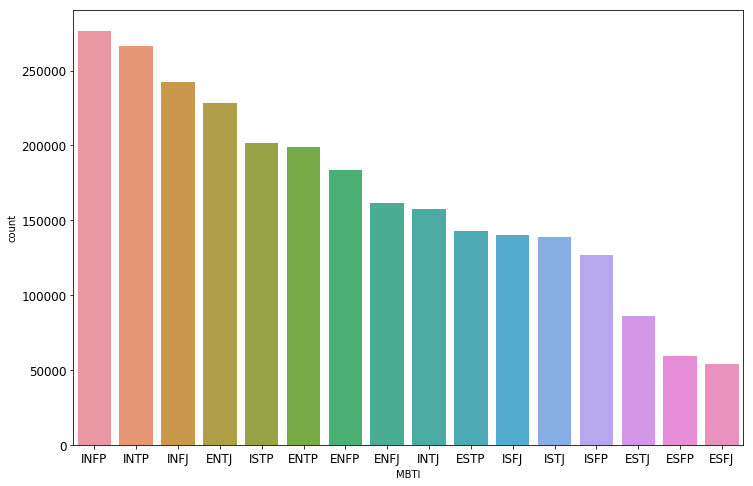

In [6]:
# plot out the distribution of data 
plt.figure(figsize=(12,8))
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
sns.countplot(data=df, x=df['MBTI'],order=df['MBTI'].value_counts().index)
plt.show()

From the above graph we can see that the classes are highly imbalanced and they are causing a big problem to the classification models. Although the distribution reflects the personalities' distribution among the population, for this project's sake, I will have to introduce some bias - manually balancing the data. I will undersample the majorities to the same level as the minority class.

A much reduced dataset will also help with the computation time.

In [8]:
# use imblearn's randomundersampler 
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()

X = df[['comments_lemma']]
y = df[['MBTI']]

X_resampled, y_resampled = rus.fit_resample(X,y)

AttributeError: 'DataFrame' object has no attribute 'name'

In [54]:
# convert resamped X and y to series and join back together as a new df 
X_resampled = pd.Series(X_resampled.tolist()).apply(lambda x: ' '.join(x))
y_resampled = pd.Series(y_resampled.tolist()).apply(lambda x: ' '.join(x))

# put the X_resample and y_resampled back together to a df 
df_resampled = pd.concat([X_resampled,y_resampled],axis=1).reset_index(drop=True)
df_resampled.columns = ['text', 'MBTI']

In [56]:
df_resampled.head(10)

,text,MBTI
0,video like particular downvote show tutorial r...,ENFJ
1,tolkien middle earth book especially silnarill...,ENFJ
2,halfway inferno shut amazing,ENFJ
3,must precise eye color green neutral l oreal p...,ENFJ
4,dunno expert acquisition work assume big role ...,ENFJ
5,geez totally miss fact mean literally win thin...,ENFJ
6,really fucking old,ENFJ
7,volunteer tribute,ENFJ
8,enfp,ENFJ
9,nope go freewill,ENFJ


In [55]:
# count the values again 
df_resampled['MBTI'].value_counts()

ENTJ    54204
ENTP    54204
ESTP    54204
INFJ    54204
ENFJ    54204
ISTJ    54204
ESTJ    54204
ISTP    54204
ISFJ    54204
ESFJ    54204
INFP    54204
ISFP    54204
INTJ    54204
ENFP    54204
INTP    54204
ESFP    54204
Name: MBTI, dtype: int64

In [57]:
# save the resampled dataset as csv file for future use
df_resampled.to_csv('../../clean_data/resampled.csv')

### TFIDF Vectorizer - Find the top words 

In [3]:
list_personality = df_resampled['MBTI']
list_posts = df_resampled['text']

In [9]:
list_posts_enfj = df_resampled.loc[df_resampled['MBTI']=='ENFJ', 'text']

In [4]:
# vectorize with count vectorizer 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cnvectorizer = CountVectorizer(tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
                             ngram_range=(1,2)) 

In [4]:
MBTI_list = ['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP']

In [6]:
# Vectorize with count and tf-idf
# keep the words appearing in 1000 to 90% of the posts.
# ngram is set to 2

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidfizer = TfidfVectorizer(tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
                             ngram_range=(1,2),
                             max_df=0.9,
                             min_df=1000) 
                           
#X_cnt = cntizer.fit_transform(list_posts).toarray()                                 
X_tfidf = tfidfizer.fit_transform(list_posts).toarray()

In [15]:
# Find out the top 5 words/phrases for each personalities
n = 5

for personality in MBTI_list:
    list_post_type = df_resampled.loc[df_resampled['MBTI'] == personality, 'text']
    list_tfidf = tfidfizer.transform(list_post_type)
    
    feature_array = np.array(tfidfizer.get_feature_names())
    tfidf_sorting = np.argsort(list_tfidf.toarray()).flatten()[::-1]
    
    sorted_feature =feature_array[tfidf_sorting]
    
    unigrams = [v for v in sorted_feature if len(v.split(' ')) == 1]
    bigrams = [v for v in sorted_feature if len(v.split(' ')) == 2]

    
    print('The Most Frequently Used Words for', personality, 'is: ', unigrams[:n])
    print('The Most Frequently Used Bigrams for', personality, 'is: ', bigrams[:n])

The Most Frequently Used Words for ENFJ is:  ['google', 'love', 'sure', 'zone', 'forward']
The Most Frequently Used Bigrams for ENFJ is:  ['find way', 'first place', 'first time', 'good job', 'good idea']
The Most Frequently Used Words for ENFP is:  ['good', 'recall', 'tree', 'ground', 'exact']
The Most Frequently Used Bigrams for ENFP is:  ['last night', 'find way', 'first place', 'first time', 'good friend']
The Most Frequently Used Words for ENTJ is:  ['lie', 'cheat', 'website', 'put', 'person']
The Most Frequently Used Bigrams for ENTJ is:  ['find way', 'first time', 'first place', 'good idea', 'good friend']
The Most Frequently Used Words for ENTP is:  ['alternative', 'see', 'really', 'zone', 'forum']
The Most Frequently Used Bigrams for ENTP is:  ['find way', 'first place', 'first time', 'good luck', 'good job']
The Most Frequently Used Words for ESFJ is:  ['please', 'zone', 'forward', 'french', 'freedom']
The Most Frequently Used Bigrams for ESFJ is:  ['find way', 'first time', 

In [47]:
tfidfizer.vocabulary_

{'video': 2170,
 'like': 1113,
 'particular': 1414,
 'downvote': 535,
 'show': 1803,
 'really': 1614,
 'helpful': 903,
 'steal': 1898,
 'waste': 2195,
 'people': 1430,
 'time': 2057,
 'generally': 798,
 'wrong': 2292,
 'dick': 502,
 'also': 63,
 'one': 1369,
 'actually': 26,
 'make': 1182,
 'personal': 1455,
 'attack': 140,
 'waste time': 2196,
 'middle': 1249,
 'earth': 559,
 'book': 225,
 'especially': 618,
 'write': 2289,
 'love': 1166,
 'old': 1367,
 'influence': 983,
 'want': 2186,
 'create': 432,
 'explain': 666,
 'know': 1060,
 'language': 1073,
 'develop': 499,
 'change': 294,
 'focus': 753,
 'lot': 1161,
 'fine': 733,
 'find': 731,
 'need': 1314,
 'story': 1910,
 'child': 304,
 'kid': 1053,
 'connect': 382,
 'main': 1177,
 'work': 2252,
 'shut': 1805,
 'amazing': 71,
 'must': 1298,
 'eye': 677,
 'color': 340,
 'green': 859,
 'neutral': 1321,
 'match': 1211,
 'perfectly': 1449,
 'dunno': 553,
 'expert': 665,
 'assume': 136,
 'big': 203,
 'role': 1702,
 'since': 1815,
 'high': 9

### Refit the Models

#### Naive Bayes

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(df_resampled['text'], df_resampled['MBTI'], random_state = 42, stratify=df_resampled['MBTI'])
X_train_tfidf = tfidfizer.fit_transform(X_train)

In [65]:
mynb = MultinomialNB().fit(X_train_tfidf, y_train)

In [66]:
X_test_tfidf = tfidfizer.transform(X_test)

In [67]:
y_pred = mynb.predict(X_test_tfidf)

In [68]:
print('Accuracy Score: ', mynb.score(X_test_tfidf, y_test))
print(classification_report(y_test, y_pred))

Accuracy Score:  0.13466257102796841
              precision    recall  f1-score   support

        ENFJ       0.10      0.12      0.11     13551
        ENFP       0.11      0.04      0.06     13551
        ENTJ       0.11      0.08      0.10     13551
        ENTP       0.15      0.07      0.10     13551
        ESFJ       0.15      0.35      0.21     13551
        ESFP       0.16      0.22      0.19     13551
        ESTJ       0.17      0.27      0.21     13551
        ESTP       0.13      0.18      0.15     13551
        INFJ       0.11      0.05      0.07     13551
        INFP       0.09      0.04      0.06     13551
        INTJ       0.12      0.12      0.12     13551
        INTP       0.10      0.05      0.07     13551
        ISFJ       0.14      0.11      0.12     13551
        ISFP       0.14      0.12      0.13     13551
        ISTJ       0.12      0.13      0.12     13551
        ISTP       0.15      0.20      0.17     13551

    accuracy                           0.13

#### Logistic Regression

In [11]:
# try Logistic Regression

mylogit = LogisticRegression(max_iter=100)
mylogit.fit(X_train_tfidf, y_train)
mylogit.score(X_test_tfidf, y_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.13693596740717964

#### Parameter Tuning

I decide to manually tune C value for logistic regression to see if it will help with the accuracy... well, not really. 

In [27]:
c_value = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
test_scores = []

for c in c_value:
    mylogit=LogisticRegression(solver='saga',penalty='l2',C=c)
    mylogit.fit(X_train_tfidf,y_train)
    score = mylogit.score(X_test_tfidf, y_test)
    
    test_scores.append(score)
    

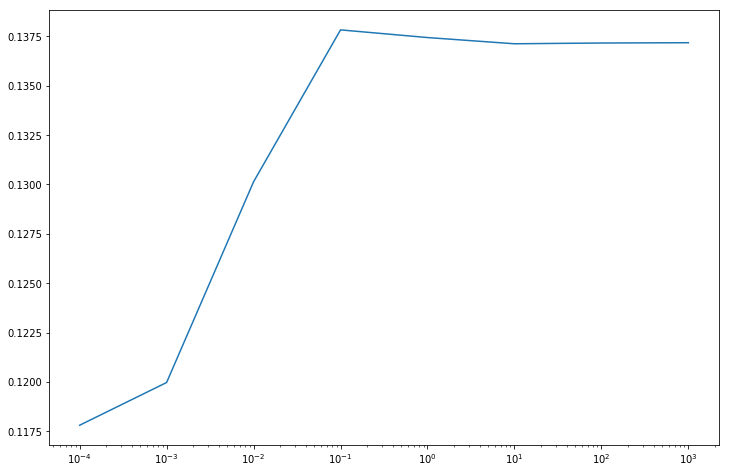

In [31]:
# plot out the test scores
plt.figure(figsize=(12,8))
plt.plot(c_value, test_scores)
plt.xscale('log')
plt.show()

In [32]:
# pick c value = 0.1, refit the model 
mylogit = LogisticRegression(solver='saga', penalty='l2', C=0.1)
mylogit.fit(X_train_tfidf, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

Below I try to fit the model on the test data set which I set aside, there are some errors which I haven't got time to figure out yet. That's for the next.

In [37]:
df_test = pd.read_csv('test_data.csv', index_col=0)

In [44]:
X_test_final = df_test['comments_lemma']
y_test_final = df_test['MBTI']

X_test_final_tfidf = tfidfizer.transform(X_test_final)

In [40]:
mylogit.score(X_test_final_tfidf, y_test_final)

ValueError: X has 3 features per sample; expecting 1681

Ok, it actually did worse than all the models before balancing the data. Now I have started to questioning myself... but I still want to try a GridSearch.

### GridSearch 2.0

As I did before, I sampled a subset of the data to perform GridSearch. I made the judgement call to do that because of the time restraints at the time. I will need to review Hadoop and MapReduce to see if there are better ways to handle the parameter tuning/gridsearch.

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
# make a sample set of data and run GridSearch 
df_sample = df_resampled.sample(n=10000)

In [20]:
X_sample = df_sample['text']
y_sample = df_sample['MBTI']

X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state = 42, stratify=y_sample)

In [21]:
X_sample_tfidf=tfidfizer.fit_transform(X_sample_train)

In [22]:
X_sample_tfidf_test=tfidfizer.transform(X_sample_test)

In [23]:
pipeline = Pipeline([('model', LogisticRegression())])

param_grid = [
    # Logistic Regression
    {'model':[LogisticRegression(solver='saga')],
    'model__penalty':['l1','l2'], 'model__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    
    # Random Forest
    {'model':[RandomForestClassifier()],
     'model__n_estimators': [50, 100, 150, 200], 'model__max_depth':[2, 5, 10, 15, 20]},
    
    # XG Boost
    {'model':[XGBClassifier()], 'model__learning_rate': [0.1, 0.5, 1, 2],
     'model__n_estimators': [50, 100, 150, 200], 'model__max_depth':[2, 5, 10, 15, 20]},
    
    # SGDClassfier
    {'model':[SGDClassifier(loss='hinge',penalty='l2',random_state=42, max_iter=5, tol=None)],
     'model__alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
    
    
    # MLP Classifier - SKlearn's Neural Network 
    {'model':[MLPClassifier(solver='adam')], 'model__max_iter':[10, 50, 100, 150, 200],
     'model__hidden_layer_sizes':[50, 100, 150, 200, 250, 300, 350, 400, 450, 500]},
    
]

grid = GridSearchCV(pipeline, param_grid, cv=5, verbose=10, n_jobs=-1)
fittedgrid = grid.fit(X_sample_tfidf, y_sample_train)

fittedgrid.score(X_sample_tfidf_test, y_sample_test)

# Save the model 
joblib.dump(grid.best_estimator_, 'bestmodel_1210.pkl', compress = 1)

Fitting 5 folds for each of 173 candidates, totalling 865 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 229 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  

['bestmodel_1210.pkl']

In [24]:
fittedgrid.best_estimator_

Pipeline(memory=None,
     steps=[('model', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False))])

In [25]:
grid_results = pd.concat([pd.DataFrame(fittedgrid.cv_results_["params"]),pd.DataFrame(fittedgrid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1).sort_values(by='Accuracy', ascending = False)

In [26]:
grid_results.head(10)

,model,model__C,model__alpha,model__hidden_layer_sizes,model__learning_rate,model__max_depth,model__max_iter,model__n_estimators,model__penalty,Accuracy
15,"LogisticRegression(C=100, class_weight=None, d...",1000.0,NaN,NaN,NaN,NaN,NaN,NaN,l2,0.073000
14,"LogisticRegression(C=100, class_weight=None, d...",1000.0,NaN,NaN,NaN,NaN,NaN,NaN,l1,0.073000
13,"LogisticRegression(C=100, class_weight=None, d...",100.0,NaN,NaN,NaN,NaN,NaN,NaN,l2,0.073000
12,"LogisticRegression(C=100, class_weight=None, d...",100.0,NaN,NaN,NaN,NaN,NaN,NaN,l1,0.073000
10,"LogisticRegression(C=100, class_weight=None, d...",10.0,NaN,NaN,NaN,NaN,NaN,NaN,l1,0.072857
11,"LogisticRegression(C=100, class_weight=None, d...",10.0,NaN,NaN,NaN,NaN,NaN,NaN,l2,0.072857
8,"LogisticRegression(C=100, class_weight=None, d...",1.0,NaN,NaN,NaN,NaN,NaN,NaN,l1,0.072857
9,"LogisticRegression(C=100, class_weight=None, d...",1.0,NaN,NaN,NaN,NaN,NaN,NaN,l2,0.072857
128,"MLPClassifier(activation='relu', alpha=0.0001,...",NaN,NaN,100.0,NaN,NaN,10.0,NaN,NaN,0.072571
126,"MLPClassifier(activation='relu', alpha=0.0001,...",NaN,NaN,50.0,NaN,NaN,150.0,NaN,NaN,0.072286


The results are all so pretty bad....

### Use 2 best models on complete set

In [11]:
# use 2 best models to form a new pipeline and fit to the train set - just try it out 

pipeline1 = Pipeline([('model', LogisticRegression())])

param_grid1 = [
    # Logistic Regression
    {'model':[LogisticRegression(solver='saga', penalty='l2', C=1.0)]},
    
    # Random Forest
    {'model':[RandomForestClassifier(n_estimators=50, max_depth=5)]},
]

grid1 = GridSearchCV(pipeline1, param_grid1, cv=5, verbose=10, n_jobs=-1)
fittedgrid1 = grid1.fit(X_train_tfidf, y_train)

fittedgrid1.score(X_test_tfidf, y_test)

joblib.dump(fittedgrid1.best_estimator_, 'bestmodel1210b.pkl', compress = 1)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   20.4s remaining:   47.5s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   22.6s remaining:   22.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.9min remaining:   48.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.1min finished


['bestmodel1210b.pkl']

In [13]:
# load in the model
best_model = joblib.load('bestmodel1210b.pkl')

In [15]:
# accuracy score
score = best_model.score(X_test_tfidf, y_test)
score

0.1374471519717119

In [16]:
y_pred = best_model.predict(X_test_tfidf)

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        ENFJ       0.12      0.08      0.09     16261
        ENFP       0.11      0.06      0.07     16261
        ENTJ       0.11      0.07      0.08     16261
        ENTP       0.13      0.08      0.10     16262
        ESFJ       0.18      0.37      0.24     16261
        ESFP       0.16      0.24      0.19     16261
        ESTJ       0.17      0.27      0.21     16262
        ESTP       0.14      0.16      0.15     16261
        INFJ       0.11      0.05      0.07     16261
        INFP       0.08      0.03      0.05     16261
        INTJ       0.12      0.10      0.11     16262
        INTP       0.08      0.11      0.10     16261
        ISFJ       0.13      0.11      0.12     16262
        ISFP       0.14      0.15      0.14     16261
        ISTJ       0.11      0.11      0.11     16261
        ISTP       0.15      0.20      0.18     16261

   micro avg       0.14      0.14      0.14    260180
   macro avg       0.13   

The best model from GridSearch did so bad, the average for the newly balanced set are all much worse than before. I think at this moment, I have come to the conclusion that downsampling is a bad idea! 

### Experiment: Facebook's FastText 

I heard FastText has a great classifier tool, so I want to give it a try. It actually gave the best result for the balanced dataset. I would definitely try to play with it on the original set when I got more AWS credits. You are welcome to skip this section and go straight to the Topic Modelling. 

In [23]:
! pip install fasttext

     |████████████████████████████████| 61kB 2.3MB/s eta 0:00:011
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2113890 sha256=d357596b666ad8ffe106196bc93b22e96663ee9162475892fef0d403ed856efc
  Stored in directory: /home/ec2-user/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fasttext


In [2]:
import fasttext

#### 1. Convert the data to FastText format

In [3]:
df_resampled = pd.read_csv('resampled.csv', index_col=0)

In [4]:
# convert input file to FastText format: __label__ sentence 1
from io import StringIO
import csv

col = ['MBTI', 'text']

df_fasttext = df_resampled[col]
df_fasttext['MBTI']=['__label__'+ s for s in df_fasttext['MBTI']]
#data_sample['comments_lemma']= data_sample['comments_lemma'].replace('\n',' ', regex=True).replace('\t',' ', regex=True)
df_fasttext.to_csv(r'fasttextsample.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

In [5]:
df_fasttext.head()

,MBTI,text
0,__label__ENFJ,video like particular downvote show tutorial r...
1,__label__ENFJ,tolkien middle earth book especially silnarill...
2,__label__ENFJ,halfway inferno shut amazing
3,__label__ENFJ,must precise eye color green neutral l oreal p...
4,__label__ENFJ,dunno expert acquisition work assume big role ...


In [6]:
df_fasttext.tail()

,MBTI,text
867259,__label__ISTP,anthony taylor cunt
867260,__label__ISTP,well pretty amazing understand completely
867261,__label__ISTP,also digital copy sure save often card get rea...
867262,__label__ISTP,weeaboo generally consider someone waaaaaay an...
867263,__label__ISTP,yeah think could laugh easily people would mak...


In [7]:
# split the data to two files
from sklearn.model_selection import train_test_split

X = df_fasttext.text
y = df_fasttext.MBTI

X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_rest, y_rest, test_size = 0.3, stratify=y_rest, random_state=42)

In [8]:
train_df = pd.concat([y_train, X_train], axis = 1)
valid_df = pd.concat([y_valid, X_valid], axis = 1)
test_df = pd.concat([y_test, X_test], axis = 1)
train_df.to_csv(r'fasttextsample_train.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")
valid_df.to_csv(r'fasttextsample_valid.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")
test_df.to_csv(r'fasttextsample_test.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

#### Input the data into the model

In [9]:
#  train the model 
# adjust epochs
epochs = range(1,51)
test_scores = []

for epoch in epochs: 
    model = fasttext.train_supervised(input='fasttextsample_train.txt', epoch = epoch, lr= 1.0, 
                                      wordNgrams = 2, bucket = 200000, dim=50, loss='hs')
    score = model.test('fasttextsample_valid.txt')[1]
    test_scores.append(score)

    

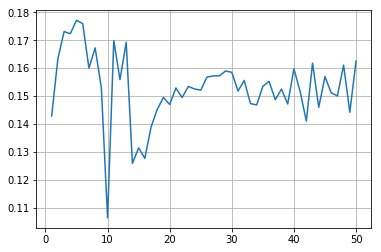

In [10]:
plt.figure()
plt.plot(epochs, test_scores)
plt.grid()
plt.show()

In [11]:
test_scores

[0.1428900870825692,
 0.16335943248081,
 0.17308896039005964,
 0.17230378968406487,
 0.17713560941326334,
 0.17590569166401282,
 0.15999912148732195,
 0.16721939755993104,
 0.15287218738675423,
 0.10632199685931717,
 0.1698549355940393,
 0.1558536397878392,
 0.16924546742365176,
 0.1258524318329069,
 0.1314200059299606,
 0.1276808363440695,
 0.13888187298902957,
 0.1452510899047912,
 0.1494679507593644,
 0.14694771751424837,
 0.1528666966825165,
 0.14942951582970032,
 0.15343223921900223,
 0.15250980090706434,
 0.15208701668075947,
 0.1567760780997771,
 0.1571933716218442,
 0.15721533443879512,
 0.15894490627367866,
 0.15848917782194744,
 0.1517685558349714,
 0.1555736138717152,
 0.14730461328970054,
 0.14677201497864117,
 0.15348165555714177,
 0.15524417161745166,
 0.14866081723641875,
 0.152476856681638,
 0.14713989216256876,
 0.15973007697967342,
 0.1516422696375037,
 0.1409903034163162,
 0.16176163754763187,
 0.14592644652603143,
 0.15694079922690884,
 0.15117555977729705,
 0.15001

In [12]:
# adjust learning rate

learning_rates = np.arange(0.1,1.0,0.1)
test_scores1 = []

for learning_rate in learning_rates: 
    model = fasttext.train_supervised(input='fasttextsample_train.txt', epoch = 5, lr= learning_rate, 
                                      wordNgrams = 2, bucket = 200000, dim=50, loss='hs')
    score = model.test('fasttextsample_valid.txt')[1]
    test_scores1.append(score)

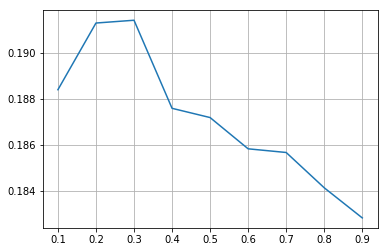

In [13]:
plt.figure()
plt.plot(learning_rates, test_scores1)
plt.grid()
plt.show()

In [14]:
test_scores1

[0.18838606239636296,
 0.19127966352964432,
 0.19140045902287428,
 0.18757892887341732,
 0.18717810746406335,
 0.18582190351734512,
 0.1856626730944511,
 0.18413076661212568,
 0.182823979003547]

In [15]:
# final model 
model = fasttext.train_supervised(input='fasttextsample_train.txt', epoch = 5, lr= 0.3, 
                                      wordNgrams = 2, bucket = 200000, dim=50, loss='hs')
# save the model 
model.save_model('fasttext_model.bin')

In [16]:
# test on test set 
model.test('fasttextsample_test.txt')

(260180, 0.1900799446537013, 0.1900799446537013)

## LDA Topic Modelling with Gensim

In [19]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Steps: 
1. Import the data
2. Lemmatize the data & remove stop words
3. Create dictionary and corpus 
4. train the model

### Create a Dictionary 

I picked two contrast personalties for topic modelling. I want to see if these people do talk about different topics online or they actually are interested in the same issues. Because the personalities are all self-identified, so it is also a way to see how accurate the personality types reflect their online interest/behaviours.

In [62]:
# Separate a df ESFJ & INTP for LDA topic modelling
df_esfj = df_resampled[df_resampled['MBTI']=='ESFJ']
df_intp = df_resampled[df_resampled['MBTI']=='INTP']

In [3]:
df_esfj = pd.read_csv('df_esfj.csv',index_col=0)
df_intp = pd.read_csv('df_intp.csv',index_col=0)

In [4]:
print('ESFJ:', df_esfj.shape)
print('INTP:', df_intp.shape)

ESFJ: (54204, 2)
INTP: (54204, 2)


In [5]:
df_esfj.head(20)

,text,MBTI
216816,enjoy ridiculous article affordable watch one ...,ESFJ
216817,yup exactly story grow mom would cook one mayb...,ESFJ
216818,unfortunately,ESFJ
216819,wow time change back release match ghz believe...,ESFJ
216820,annoy want keep reading journal,ESFJ
216821,would go around northeast usa visit big city,ESFJ
216822,lewis write bit believe screwtape letters some...,ESFJ
216823,would runaway groom anything,ESFJ
216824,refuse work chrome work fine safari,ESFJ
216825,part reason one kid everyone else around like ...,ESFJ


In [6]:
df_intp.head(20)

,text,MBTI
596244,hear amd car driver crash,INTP
596245,one sell tomato grocery store,INTP
596246,nox definitely nox,INTP
596247,yeah well fuck,INTP
596248,society value man primarily base successful pe...,INTP
596249,tell anything would convey experience taste so...,INTP
596250,fair never actually house mate room mate live ...,INTP
596251,extremely entj maybe estp like season master s...,INTP
596252,want buy preyta seem really mana hungry right ...,INTP
596253,georgeous lt,INTP


In [7]:
import gensim
from gensim import corpora
from pprint import pprint

# How to create a dictionary from a list of sentences
documents_esfj = df_esfj['text'].tolist( )
documents_intp = df_intp['text'].tolist( )


# Tokenize(split) the sentences into words
texts_esfj = [[text for text in doc.split()] for doc in documents_esfj]
texts_intp = [[text for text in doc.split()] for doc in documents_intp]

# Create dictionary
dictionary_esfj = corpora.Dictionary(texts_esfj)
dictionary_intp = corpora.Dictionary(texts_intp)


# Get information about the dictionary
print(dictionary_esfj)
print(dictionary_intp)

Dictionary(30936 unique tokens: ['affordable', 'article', 'enjoy', 'gaudy', 'gold']...)
Dictionary(53175 unique tokens: ['amd', 'car', 'crash', 'driver', 'hear']...)


### Create a Corpus 

In [8]:
# Create the Corpus
corpus_esfj = [dictionary_esfj.doc2bow(doc, allow_update=True) for doc in texts_esfj]
corpus_intp = [dictionary_intp.doc2bow(doc, allow_update=True) for doc in texts_intp]

In [9]:
# print out the word count of first 6 comments
word_counts_esfj = [[(dictionary_esfj[id], count) for id, count in line] for line in corpus_esfj]
word_counts_intp = [[(dictionary_intp[id], count) for id, count in line] for line in corpus_intp]

print('ESFJ examples: ', word_counts_esfj[:5])

print('INTP examples:', word_counts_intp[:5])

ESFJ examples:  [[('affordable', 1), ('article', 1), ('enjoy', 1), ('gaudy', 1), ('gold', 1), ('one', 1), ('ridiculous', 1), ('watch', 1)], [('one', 3), ('watch', 1), ('actually', 1), ('ask', 1), ('away', 2), ('bet', 1), ('big', 1), ('boil', 1), ('bowl', 1), ('busy', 1), ('cook', 1), ('corn', 3), ('could', 2), ('country', 1), ('ear', 1), ('eat', 1), ('exactly', 1), ('first', 1), ('four', 1), ('front', 1), ('give', 1), ('go', 1), ('good', 1), ('grain', 1), ('grow', 2), ('handle', 1), ('happen', 1), ('hear', 1), ('horrify', 1), ('insult', 1), ('keep', 1), ('later', 1), ('leave', 1), ('leftover', 3), ('look', 1), ('maybe', 1), ('meal', 1), ('mom', 2), ('per', 1), ('puzzled', 1), ('really', 1), ('rest', 1), ('rice', 1), ('roommate', 1), ('see', 2), ('shocked', 1), ('starve', 1), ('story', 1), ('third', 1), ('throw', 2), ('time', 1), ('turn', 1), ('two', 1), ('week', 2), ('work', 2), ('world', 1), ('would', 3), ('yup', 1)], [('unfortunately', 1)], [('give', 1), ('time', 1), ('amd', 1), ('ba

### Save Dictionary and Corpus

In [76]:
# Save the Dict and Corpus
dictionary_esfj.save('dictionary_esfj.dict')
dictionary_intp.save('dictionary_intp.dict')

corpora.MmCorpus.serialize('corpus_esfj.mm', corpus_esfj)
corpora.MmCorpus.serialize('corpus_intp.mm', corpus_intp)  

### TF-IDF weights 

In [10]:
from gensim import models

# Create the TF-IDF model
tfidf_esfj = models.TfidfModel(corpus_esfj, smartirs='ntc')
tfidf_intp = models.TfidfModel(corpus_intp, smartirs='ntc')

# Show the TF-IDF weights of the first lines of ESFJ and INTP
for doc in tfidf_esfj[corpus_esfj[:1]]:
    print([[dictionary_esfj[id], np.around(freq, decimals=2)] for id, freq in doc])

for doc in tfidf_intp[corpus_intp[:1]]:
    print([[dictionary_intp[id], np.around(freq, decimals=2)] for id, freq in doc])

[['affordable', 0.44], ['article', 0.31], ['enjoy', 0.23], ['gaudy', 0.6], ['gold', 0.34], ['one', 0.11], ['ridiculous', 0.36], ['watch', 0.21]]
[['amd', 0.57], ['car', 0.37], ['crash', 0.48], ['driver', 0.46], ['hear', 0.31]]


### Bi-grams and Tri-grams

#### Bi-grams

In [11]:
from gensim.models import Phrases

# remove double and leading space 
# dataset = [re.sub(' +', ' ', wd) for wd in dataset]
# dataset = [wd.lstrip(' ') for wd in dataset]

# split the sentences 
sentence_esfj = [doc.split(' ') for doc in documents_esfj]
sentence_intp = [doc.split(' ') for doc in documents_intp]

# Build the bigram models
bigram_esfj = Phrases(sentence_esfj, min_count=1, threshold=10)
bigram_intp = Phrases(sentence_intp, min_count=1, threshold=10)

# faster way to get a sentene clubbed as a bigram
bigram_model_esfj = gensim.models.phrases.Phraser(bigram_esfj)
bigram_model_intp = gensim.models.phrases.Phraser(bigram_intp)

# try on a sentence
sent_esfj = sentence_esfj[4]
sent_intp = sentence_intp[4]

# try bigrammodel
print(bigram_model_esfj[sent_esfj])
print(bigram_model_intp[sent_intp])

['annoy', 'want', 'keep', 'reading_journal']
['society', 'value', 'man', 'primarily_base', 'successful', 'people', 'accomplish_much', 'term', 'career_success', 'big', 'year', 'professional_advancement', 'also', 'gain', 'value', 'meanwhile_woman', 'look', 'settle', 'raise_family', 'usually', 'want', 'early', 'still', 'relatively', 'safe', 'kid', 'willing_settle', 'caveat', 'magical', 'number', 'anything', 'life', 'suddenly_become', 'successful', 'figure', 'want', 'get', 'establish', 'field', 'take', 'time']


#### Tri-grams

Unfortunately in this case, I didn't find any trigrams...

In [25]:
# Build the trigram models - try to see if there is any 
trigram_esfj = Phrases(bigram_esfj[sentence_esfj], threshold=10)
trigram_intp = Phrases(bigram_intp[sentence_esfj], threshold=10)

# Construct trigram
print(trigram_esfj[bigram_esfj[sent_esfj]])
print(trigram_intp[bigram_intp[sent_intp]])

['annoy', 'want', 'keep', 'reading_journal']
['society', 'value', 'man', 'primarily_base', 'successful', 'people', 'accomplish_much', 'term', 'career_success', 'big', 'year', 'professional_advancement', 'also', 'gain', 'value', 'meanwhile_woman', 'look', 'settle', 'raise_family', 'usually', 'want', 'early', 'still', 'relatively', 'safe', 'kid', 'willing_settle', 'caveat', 'magical', 'number', 'anything', 'life', 'suddenly_become', 'successful', 'figure', 'want', 'get', 'establish', 'field', 'take', 'time']


### Topic Modelling 

#### Data Prep

In [12]:
from gensim.models import LdaModel, LdaMulticore
import gensim.downloader as api
from gensim.utils import simple_preprocess, lemmatize
from nltk.corpus import stopwords


import re

stop_words = stopwords.words('english')
stop = ['to', 'of', 'the', 'be', 'for', 'that', 'do', 'have', 'this', 'and']
stop_words = stop_words + stop

In [192]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
# create bi-grams
processed_bigram_esfj = [bigram_model_esfj[doc] for doc in sentence_esfj]
processed_bigram_intp = [bigram_model_intp[doc] for doc in sentence_intp]

In [28]:
# see the examples 
print(processed_bigram_esfj[:5])
print(processed_bigram_intp[:5])

[['enjoy', 'ridiculous', 'article', 'affordable', 'watch', 'one', 'gaudy', 'gold'], ['yup_exactly', 'story', 'grow', 'mom', 'would', 'cook', 'one', 'maybe', 'two', 'big', 'meal_per', 'week', 'would', 'work', 'leftover_rest', 'week', 'busy', 'work', 'mom', 'grow_starve', 'third', 'world', 'country', 'leave', 'one', 'grain_rice', 'bowl_bet', 'would', 'hear', 'later', 'see', 'shocked_horrify', 'see', 'insult_leftover', 'happen', 'front', 'first', 'time', 'roommate_boil', 'four_ear', 'corn_eat', 'one', 'go', 'throw_away', 'actually', 'ask', 'could', 'keep_leftover', 'corn', 'could_handle', 'watch', 'throw_away', 'look_puzzled', 'give', 'turn', 'really', 'good', 'corn'], ['unfortunately'], ['wow', 'time', 'change', 'back', 'release', 'match_ghz', 'believe', 'slightly', 'strong', 'x_x', 'slightly_overclocke', 'clock', 'high_ghz', 'editon_beat', 'rebrand_guess', 'year_amd', 'give', 'support_nvidia', 'probably', 'help_rebrande', 'ton'], ['annoy', 'want', 'keep', 'reading_journal']]
[['hear', '

In [14]:
# Step 3: Create the Inputs of LDA model: Dictionary and Corpus
dct_esfj = corpora.Dictionary(processed_bigram_esfj)
dct_intp = corpora.Dictionary(processed_bigram_intp)

corp_esfj = [dct_esfj.doc2bow(line) for line in processed_bigram_esfj]
corp_intp = [dct_intp.doc2bow(line) for line in processed_bigram_intp]

#### LDA Modelling

In [38]:
# train the model 
# Step 4: Train the LDA model
lda_model_esfj = LdaMulticore(corpus=corp_esfj,
                         id2word=dct_esfj,
                         random_state=100,
                         num_topics=10,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

Process ForkPoolWorker-74:
Process ForkPoolWorker-62:
Process ForkPoolWorker-76:
Process ForkPoolWorker-89:
Process ForkPoolWorker-67:
Process ForkPoolWorker-81:
Process ForkPoolWorker-77:
Process ForkPoolWorker-93:
Process ForkPoolWorker-65:
Process ForkPoolWorker-87:
Process ForkPoolWorker-57:
Process ForkPoolWorker-79:
Process ForkPoolWorker-95:
Process ForkPoolWorker-66:
Process ForkPoolWorker-78:
Process ForkPoolWorker-91:
Process ForkPoolWorker-63:
Process ForkPoolWorker-73:
Process ForkPoolWorker-84:


KeyboardInterrupt: 

Process ForkPoolWorker-59:
Process ForkPoolWorker-68:
Process ForkPoolWorker-64:
Process ForkPoolWorker-60:
Process ForkPoolWorker-82:
Process ForkPoolWorker-92:
Process ForkPoolWorker-58:
Process ForkPoolWorker-88:
Process ForkPoolWorker-83:
Process ForkPoolWorker-86:
Process ForkPoolWorker-85:
Process ForkPoolWorker-90:
Process ForkPoolWorker-56:
Process ForkPoolWorker-75:
Process ForkPoolWorker-61:
Process ForkPoolWorker-94:
Process ForkPoolWorker-80:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most 

  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **sel

  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/ec2-user/anaconda3/envs/python3/

  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6

  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
KeyboardInterrupt
Process ForkPoolWorker-70:
Process ForkPoolWorker

In [ ]:
lda_model_intp = LdaMulticore(corpus=corp_intp,
                         id2word=dct_intp,
                         random_state=100,
                         num_topics=10,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

In [98]:
# save the model
lda_model_esfj.save('lda_model_esfj.model')
lda_model_intp.save('lda_model_intp.model')

# See the topics
lda_model_esfj.print_topics()

[(0,
  '0.018*"url" + 0.013*"thank" + 0.010*"one" + 0.010*"good" + 0.009*"love" + 0.008*"like" + 0.007*"look" + 0.007*"get" + 0.005*"go" + 0.005*"make"'),
 (1,
  '0.018*"like" + 0.017*"get" + 0.016*"would" + 0.013*"think" + 0.013*"people" + 0.012*"go" + 0.010*"really" + 0.010*"know" + 0.010*"one" + 0.009*"make"'),
 (2,
  '0.003*"decant_available" + 0.002*"uconn" + 0.002*"function" + 0.002*"look" + 0.002*"ice_cream" + 0.001*"tooth" + 0.001*"decant" + 0.001*"true" + 0.001*"fruit" + 0.001*"work"'),
 (3,
  '0.011*"funner_funner" + 0.003*"disorder" + 0.002*"url_wiki" + 0.002*"isfp" + 0.002*"url" + 0.002*"makeupaddiction" + 0.002*"personality_disorder" + 0.001*"king_landing" + 0.001*"double_major" + 0.001*"borderline_personality"'),
 (4,
  '0.047*"color" + 0.021*"look" + 0.020*"see" + 0.015*"blue" + 0.015*"red" + 0.015*"green" + 0.013*"white" + 0.013*"black" + 0.010*"light" + 0.007*"yellow"'),
 (5,
  '0.003*"use" + 0.002*"get" + 0.001*"truth" + 0.001*"point" + 0.001*"sansa" + 0.001*"treatmen

In [99]:
lda_model_intp.print_topics()

[(0,
  '0.012*"would" + 0.011*"get" + 0.010*"like" + 0.010*"think" + 0.010*"people" + 0.009*"one" + 0.008*"make" + 0.008*"go" + 0.008*"say" + 0.007*"know"'),
 (1,
  '0.044*"url" + 0.019*"thank" + 0.008*"lol" + 0.007*"yes" + 0.006*"gt" + 0.006*"look_like" + 0.006*"fuck" + 0.005*"cat" + 0.005*"jpg" + 0.005*"man"'),
 (2,
  '0.010*"team" + 0.007*"play" + 0.005*"game" + 0.004*"like" + 0.004*"k" + 0.004*"win" + 0.003*"player" + 0.003*"gt" + 0.003*"think" + 0.003*"make"'),
 (3,
  '0.004*"rape_drug" + 0.004*"ghb_date" + 0.003*"alright_alright" + 0.003*"hello" + 0.002*"shitpost" + 0.002*"ftfy" + 0.002*"holy_fuck" + 0.002*"ubuntu" + 0.002*"b" + 0.002*"der"'),
 (4,
  '0.012*"nope" + 0.005*"entj" + 0.005*"esfp" + 0.004*"esfj" + 0.004*"estp" + 0.004*"w" + 0.004*"isfj" + 0.004*"irl" + 0.003*"isfp" + 0.002*"estj"'),
 (5,
  '0.005*"horse" + 0.005*"welcome" + 0.004*"zip_gt" + 0.003*"gif" + 0.003*"ca" + 0.003*"rar_gt" + 0.002*"pony" + 0.002*"cum" + 0.002*"logo" + 0.002*"ebook"'),
 (6,
  '0.014*"v" + 0.0

#### LSI Model

In [30]:
from gensim.models import LsiModel

# Build the LSI Model
lsi_model_esfj = LsiModel(corpus=corp_esfj, id2word=dct_esfj, num_topics=10, decay=0.5)
lsi_model_intp = LsiModel(corpus=corp_intp, id2word=dct_intp, num_topics=10, decay=0.5)

# View Topics
pprint(lsi_model_esfj.print_topics(-1))
pprint(lsi_model_intp.print_topics(-1))

[(0,
  '0.344*"like" + 0.281*"would" + 0.278*"get" + 0.246*"people" + 0.210*"think" '
  '+ 0.205*"thing" + 0.196*"go" + 0.186*"really" + 0.163*"make" + 0.160*"one"'),
 (1,
  '1.000*"funner_funner" + 0.008*"funner" + -0.000*"everyone" + 0.000*"keep" + '
  '-0.000*"type" + -0.000*"hate" + -0.000*"already" + -0.000*"pay" + '
  '0.000*"gt" + -0.000*"hear"'),
 (2,
  '0.623*"get" + -0.603*"like" + 0.240*"go" + -0.218*"people" + -0.109*"feel" '
  '+ -0.107*"think" + 0.102*"time" + 0.087*"take" + -0.084*"thing" + '
  '0.075*"want"'),
 (3,
  '-0.800*"would" + 0.419*"people" + 0.206*"get" + 0.165*"thing" + 0.092*"lot" '
  '+ -0.082*"think" + -0.080*"kid" + -0.079*"like" + -0.079*"go" + '
  '0.075*"well"'),
 (4,
  '0.617*"like" + -0.458*"people" + 0.338*"get" + -0.298*"would" + '
  '-0.219*"think" + 0.136*"go" + -0.128*"see" + -0.107*"thing" + 0.103*"kid" + '
  '-0.078*"well"'),
 (5,
  '0.529*"people" + 0.396*"get" + -0.317*"see" + 0.272*"would" + -0.248*"one" '
  '+ -0.164*"make" + 0.149*"like" 

#### Compute Model Perplexity and Coherence Score

In [101]:
# Compute Perplexity
print('\nESFJ Perplexity: ', lda_model_esfj.log_perplexity(corp_esfj))
print('\nINTP Perplexity: ', lda_model_intp.log_perplexity(corp_intp))

# Compute Coherence Score 
coherence_model_esfj = CoherenceModel(model=lda_model_esfj, texts=processed_bigram_esfj, dictionary=dct_esfj, coherence='c_v')
coherence_esfj = coherence_model_esfj.get_coherence()
print('\nESFJ Coherence Score: ', coherence_esfj)

coherence_model_intp = CoherenceModel(model=lda_model_intp, texts=processed_bigram_intp, dictionary=dct_intp, coherence='c_v')
coherence_intp = coherence_model_intp.get_coherence()
print('\nINTP Coherence Score: ', coherence_intp)


ESFJ Perplexity:  -8.376806543613682

INTP Perplexity:  -8.912526472268127

ESFJ Coherence Score:  0.5237966081240052

INTP Coherence Score:  0.5570043489160339


### Find the best Number of Topics 

Before moving on to Mallet model and visualisations, I decided to find out the best number of topics for the documents.

In [116]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [117]:
# Can take a long time to run.
model_list_esfj, coherence_values_esfj = compute_coherence_values(dictionary=dct_esfj, corpus=corp_esfj, texts=processed_bigram_esfj, start=10, limit=100, step=10)

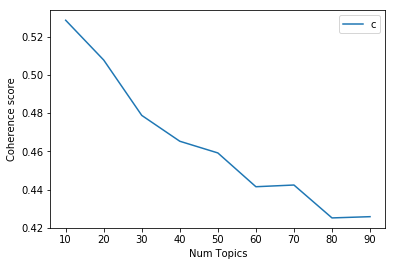

In [118]:
# Show graph
limit=100; start=10; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values_esfj)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [119]:
# Print the coherence scores
for m, cv in zip(x, coherence_values_esfj):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.5285
Num Topics = 20  has Coherence Value of 0.5077
Num Topics = 30  has Coherence Value of 0.4788
Num Topics = 40  has Coherence Value of 0.4653
Num Topics = 50  has Coherence Value of 0.4592
Num Topics = 60  has Coherence Value of 0.4416
Num Topics = 70  has Coherence Value of 0.4425
Num Topics = 80  has Coherence Value of 0.4253
Num Topics = 90  has Coherence Value of 0.426


In [122]:
# Select the model and print the topics
optimal_model_esfj = model_list_esfj[0]
model_topics = optimal_model_esfj.show_topics(formatted=False)
pprint(optimal_model_esfj.print_topics(num_words=10))

[(0,
  '0.049*"kid" + 0.027*"year" + 0.019*"lol" + 0.019*"school" + 0.018*"mom" + '
  '0.016*"parent" + 0.013*"class" + 0.013*"start" + 0.013*"husband" + '
  '0.013*"family"'),
 (1,
  '0.051*"friend" + 0.041*"time" + 0.016*"day" + 0.015*"place" + 0.014*"long" '
  '+ 0.013*"end" + 0.012*"week" + 0.011*"live" + 0.011*"back" + 0.010*"month"'),
 (2,
  '0.040*"love" + 0.033*"make" + 0.032*"good" + 0.014*"eat" + 0.011*"feel" + '
  '0.009*"day" + 0.009*"pretty" + 0.009*"hear" + 0.009*"food" + '
  '0.008*"listen"'),
 (3,
  '0.014*"good" + 0.013*"run" + 0.013*"back" + 0.011*"happen" + 0.011*"turn" + '
  '0.010*"phone" + 0.009*"game" + 0.009*"bad" + 0.008*"play" + 0.008*"car"'),
 (4,
  '0.090*"people" + 0.050*"feel" + 0.036*"thing" + 0.028*"person" + '
  '0.027*"life" + 0.024*"talk" + 0.016*"lot" + 0.013*"make" + 0.011*"friend" + '
  '0.010*"bad"'),
 (5,
  '0.047*"work" + 0.041*"good" + 0.029*"make" + 0.029*"thing" + 0.027*"time" + '
  '0.017*"learn" + 0.015*"stuff" + 0.015*"love" + 0.014*"find"

### Mallet Model

Use Mallet wrapper to find better topics, and it is indeed much better than plain LDA.

In [103]:
mallet_path = '../../mallet-2.0.8/bin/mallet' # update this path
ldamallet_esfj = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corp_esfj, num_topics=10, id2word=dct_esfj)

In [107]:
ldamallet_intp = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corp_intp, num_topics=10, id2word=dct_intp)

In [104]:
# Show Topics - ESFJ
pprint(ldamallet_esfj.show_topics(formatted=False))

[(0,
  [('people', 0.039644162267911856),
   ('feel', 0.039434990710322),
   ('guy', 0.035103909047285074),
   ('girl', 0.0188746570201666),
   ('woman', 0.017841103441487333),
   ('make', 0.017447368744847612),
   ('life', 0.017102850885287856),
   ('person', 0.015995472050988644),
   ('man', 0.01565095419142889),
   ('date', 0.01459279219420964)]),
 (1,
  [('friend', 0.05263593282832461),
   ('people', 0.05121781160259516),
   ('love', 0.042744537278861724),
   ('time', 0.03396400335622023),
   ('talk', 0.0322622578853449),
   ('thing', 0.02993417553977239),
   ('make', 0.025549817416892186),
   ('feel', 0.021874519906876708),
   ('good', 0.01916827190110968),
   ('lot', 0.018092863304931518)]),
 (2,
  [('work', 0.03111286363000369),
   ('show', 0.020975107165116958),
   ('year', 0.020644389890227304),
   ('school', 0.01901624330615516),
   ('good', 0.018939923935026776),
   ('watch', 0.018863604563898392),
   ('class', 0.018176730223742957),
   ('make', 0.018100410852614573),
   ('s

In [108]:
# Show Topics - INTP
pprint(ldamallet_intp.show_topics(formatted=False))

[(0,
  [('time', 0.03694628544437392),
   ('day', 0.02163933458308117),
   ('show', 0.018687174339823167),
   ('year', 0.017653918254682863),
   ('end', 0.016517336561028533),
   ('start', 0.015956426114809512),
   ('back', 0.013579937118986819),
   ('watch', 0.011572468153571375),
   ('great', 0.010347321652619304),
   ('character', 0.009978301622212053)]),
 (1,
  [('people', 0.055514534963218204),
   ('man', 0.012306177701206006),
   ('woman', 0.011950665900948943),
   ('make', 0.009694533322394509),
   ('state', 0.008040036098121256),
   ('society', 0.007055541882024776),
   ('problem', 0.007028194820466541),
   ('call', 0.006535947712418301),
   ('country', 0.005893291765799765),
   ('government', 0.005852271173462411)]),
 (2,
  [('money', 0.01270179055345891),
   ('buy', 0.01073999567740112),
   ('pay', 0.010606992634956524),
   ('job', 0.008046684067898054),
   ('car', 0.007414919616286222),
   ('work', 0.00714891353139703),
   ('gt', 0.0063342698964238804),
   ('part', 0.0057191

In [109]:
# Compute Coherence Score
coherence_model_ldamallet_esfj = CoherenceModel(model=ldamallet_esfj, texts=processed_bigram_esfj, dictionary=dct_esfj, coherence='c_v')
coherence_ldamallet_esfj = coherence_model_ldamallet_esfj.get_coherence()
print('\n ESFJ Coherence Score: ', coherence_ldamallet_esfj)

coherence_model_ldamallet_intp = CoherenceModel(model=ldamallet_intp, texts=processed_bigram_intp, dictionary=dct_esfj, coherence='c_v')
coherence_ldamallet_esfj = coherence_model_ldamallet_esfj.get_coherence()
print('\n ESFJ Coherence Score: ', coherence_ldamallet_esfj)


 ESFJ Coherence Score:  0.49884616111697466

 ESFJ Coherence Score:  0.49884616111697466


Because PyLDAvis only supports lda models, thus I used the function below to convert Mallet models to regular LDA models for visualisation. 

In [125]:
# function to convert Mallet model to LDA to be used in visualization 

def mallet_to_lda(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

In [129]:
# convert ldamallet models to lda models for visualization 
lda_ldamallet_esfj = mallet_to_lda(ldamallet_esfj)
lda_ldamallet_intp = mallet_to_lda(ldamallet_intp)

In [131]:
# save the converted model
lda_ldamallet_esfj.save('lda_ldamallet_esfj.model')
lda_ldamallet_intp.save('lda_ldamallet_intp.model')

### Visualise Topics - keywords & topics

These visualizations are amazing! And they provided useful insights into the user behaviours of INTP and ESFJ users. They do actually have different interests on Reddit. I have attached the two html visualisations in the zip file. The INTP people are the rational ones, they talk about money/gaming/psychology... on the other hand ESFJ people like to openly discuss relationship issues including dating life/friendship/family/appearces etc... This in a way proves that the self-identified personality indicators is at least a bit right.

In [18]:
! pip install pyLDAvis

In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_esfj = pyLDAvis.gensim.prepare(lda_ldamallet_esfj, corp_esfj, dct_esfj)
pyLDAvis.save_html(vis_esfj, 'lda_esfj.html')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(t

In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_intp = pyLDAvis.gensim.prepare(lda_ldamallet_intp, corp_intp, dct_intp)
pyLDAvis.save_html(vis_intp, 'lda_intp.html')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(t

## Limitations

There are many bias and subjective decisions in the process of this project, but  to be honest, the project is based on very biased and subjective data. I made some calls with the dataset, and one of the decisions end up hurting the performance of the models. 

There are limitations on the dataset too. User comments, especially reddit comments are extremely informal, the grammar and the spelling is poor, and there are often internet slang/emoji peppered throughout the documents. It proves to be difficult even after I processed it using different tools, almost bleached it in the end. 


## Future Improvements

There are many improvements I can see happening here. 
First, I did not get a chance to work more on LSTM and word embedding which might help with the accuracy of the models. This is the next thing I’m going to learn and work on. 

Second, to be able to use Hadoop and MapReduce would help with the volume of the dataset. I know we touched upon this during class, however, more lessons are needed. 


## Conclusion

### In response to hypothesised outcomes in proposal: 

1. Personality Classifier: The model would be able to take a comment and predict what personality the commenter is. However, due to the imbalance in the data and the number of classes, I don’t think the accuracy will be very high. 
	
**Reality:** Well,  at least I foresaw the terrible accuracy. But I was not able to build an input function for testing user real-time input.  The accuracy of the models are all relatively low. The best model is Logistic Regression before I under sample the data, it achieved 21% accuracy on precision/recall. Another promising model is FastText, even on the under sampled data, it achieved 19% accuracy. I will play with it more to see if it can go higher on original data. 

2. User segmentation: Ideally the model will be able to find some clear clusters using the text data and personalities. Then I would be able to relate them to the subreddit and build a persona for reddit users. 

**Reality:** I didn’t use unsupervised model for this, instead I used LDA topic modelling for different personality types. They actually came out great. I think it is possible to cross-reference the LDA topics / subreddits/ MBTI types to build a complete picture of the user behaviours. 

3. Overview of the Reddit: People with what kind of personalities like to use Reddit more? Is there any relationship between personalities and subreddits? 

**Reality:** I didn’t get a chance to explore anything related to subreddits. However, from the data, it’s plain to see that people with certain personalities ( INFP, INTP, INFJ, ENTJ..) like to post on Reddit more than others. Funny how internet is the playground of introverts.  

### This NLP Journey

Looking back, there are decisions I regret but in the end, these are valuable lessons. Even though NLP might not look as sophisticated as image recognition CNNs, it is one of the most important tools in tackling the largest format of unstructured data out there - text data. Users generate trillions of text everyday on the internet, it is one of the biggest data and it contains valuable information. I see NLP as gold panning, it’s a lot of hard work for those few nuggets that’s highly valuable. 

Well, in conclusion, no regrets. 